In [1]:
'''Clear out temporary variables and get a clean session'''
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

### Data preparation
The data in this dataset come from a real-world admissions board for a large high school district.  The district runs several specialized programs for which they run admissions.  As such, the data is taken from spreadsheets created over the course of 10 years.  As such, column names, admissions criteria used and data maintained over the years has changed. This initial data preparation involves getting the original data into a consistent format.  There will be no data manipulation or analysis conducted at this stage.

In [2]:
'''Import necessary libraries'''
import pandas as pd
import numpy as np
import os
import glob
import re

import missingno as msno
import pickle
import bz2

import sklearn
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import set_config
#from sklearn import missingpy

%matplotlib inline

In [3]:
'''Import all csv files in active folder and create dictionary of dataframes'''
csv_files = glob.glob('*.csv')

var_dict = {}

for file in csv_files:
    key = 'df_'+str(re.split('.csv', file)[0])
    value = pd.read_csv(file)
    var_dict[key] = value

In [4]:
'''List of all dataframes'''
var_dict.keys()

dict_keys(['df_2008_2009_ib_magnet', 'df_2009_2010_ib', 'df_2009_2010_magnet', 'df_2010-2011_ib', 'df_2010-2011_magnet', 'df_2011_2012_in_district', 'df_2011_2012_out_district', 'df_2012_2013_in_district', 'df_2012_2013_out_district', 'df_2013_2014_in_district', 'df_2013_2014_out_district', 'df_2014_2015_in_district', 'df_2014_2015_out_district', 'df_2015_2016_in_district', 'df_2015_2016_out_district', 'df_2016_2017_in_district', 'df_2016_2017_out_district', 'df_2017_2018_in_district', 'df_2017_2018_out_district', 'df_2018_2019_in_district', 'df_2018_2019_out_district', 'df_2019_2020_in_district', 'df_2019_2020_out_district', 'df_2020_2021_in_district', 'df_2020_2021_out_district', 'df_2021_2022_in_district', 'df_2021_2022_out_district'])

In [5]:
for key, item in var_dict.items():
    print(key, item.columns)

df_2008_2009_ib_magnet Index(['CL', 'L.N', 'F.N', 'ID', 'Sending District', 'Middle School', 'OHS',
       'Math Course', 'G', 'ES', 'ESC', 'ESW', 'ME', 'MEC', 'MEW', 'GP', 'GPC',
       'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC', 'RCC', 'RCW',
       'P.I.Score', 'IN', 'INC', 'INW', 'Admit Score', 'Decision',
       'Accepted Offer?', 'Reception Letter Sent', 'Reception RSVP',
       'Withdrew  in first year', 'Reason', 'GPA 1st year'],
      dtype='object')
df_2009_2010_ib Index(['Program', 'Last Name', 'First Name', 'Address', 'City', 'State', 'ZIP',
       'Home Phone', 'Sending District', 'Middle School', 'OHS', 'Math Course',
       'Foreign Language', 'Gender', 'Ethnic', 'IEP?', '504?', 'Transcript?',
       'Attendance?', 'Discipline?', 'Tests?', 'Recommendations', 'Notes',
       'ES', 'ESC', 'ESW', 'ME', 'MEC', 'MEW', 'GP', 'GPC', 'GPW', 'STE',
       'STM', 'TOTAL', 'STC', 'STW', 'RC', 'RCC', 'RCW', 'PIScore', 'IN',
       'INC', 'INW', 'Admit Score', 'Admit Status', '

In [6]:
'''List of columns to drop from original files'''
drop_columns = ['Record Created Date', '#', 'Sibling', 'NYr Grade', 'Also GHS', 'Tier', 'DOB', 'Address', 'City', 'State',\
                'ZIP', 'Home Phone', 'Work/Cell Phone', 'Parent email', 'ID', 'District of Residence', 'Sending District',\
               'Current School', 'Middle School', 'Current School', 'Current Grade', 'Grade Level', 'OHS', 'Academy?',\
               'Academy', 'Math Course', 'Gender', 'G', 'Foreign Language', 'Length', 'IEP?', 'IEP/ISP', 'IEP', '504?',\
               '504', '7th Grade Math', '7th Grade Sci', '7th Grade Eng', '7th Grade SS', '7th Grade WL', '8th Grade Math',\
               '8th Grade Sci', '8th Grade Eng', '8th Grade SS', '8th Grade WL', 'Transcripts', 'Transcript', 'Transcript?',\
               'Attendance?', 'Attendance', 'Discipline?', 'Discipline', 'Tests?', 'Recommendations', 'Recs', 'Rec',\
               'Notes', 'Notes', 'Notes.1', 'Notes.2' 'Math/Sci Rec', 'Math/Sci Adv Course', 'Eng/SS Adv Course', 'Adv Courses',\
               'Waitlist #', 'WL #', 'Withdrew  in first year', 'Withdrew', 'Reason', 'Acc Sp.', 'Acc Sp Gr', 'GPA 1st year',\
               'Prediction', 'Student email', 'Requested HS', 'Sending Supt.', 'Preference', 'Info Release consent',\
               'Tuition Code', 'Reception Letter Sent', 'Reception RSVP', 'Testing Number', 'Ethnic', 'Unnamed: 49', \
               'Unnamed: 53', 'Unnamed: 52', 'Prospect Street', 'Prospect City', 'Prospect State', 'Prospect Zip', \
               'Resident District', 'Filler', 'MCST Academy', 'P.I.Score', 'PI Score', 'PIScore', 'AX Offer?.1', 'Car Pooling info',\
               'Unnamed: 59', 'Unnamed: 60', 'Eng/SS Rec', 'Math/Sci Rec', 'Math/Sci Adv', 'Eng/SS Adv', 'Adv. Courses', \
               'Parent/Guardian Name']

drop_columns = [column.lower() for column in drop_columns]

In [7]:
'''Drop unnecessary columns from original data'''
for key, item in var_dict.items():
    for column in item.columns:
        column_lower = column.strip().lower()
        if column_lower in drop_columns:
            item.drop(column, axis=1, inplace = True)
    print(key, item.columns)

df_2008_2009_ib_magnet Index(['CL', 'L.N', 'F.N', 'ES', 'ESC', 'ESW', 'ME', 'MEC', 'MEW', 'GP', 'GPC',
       'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC', 'RCC', 'RCW', 'IN',
       'INC', 'INW', 'Admit Score', 'Decision', 'Accepted Offer?'],
      dtype='object')
df_2009_2010_ib Index(['Program', 'Last Name', 'First Name', 'ES', 'ESC', 'ESW', 'ME', 'MEC',
       'MEW', 'GP', 'GPC', 'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC',
       'RCC', 'RCW', 'IN', 'INC', 'INW', 'Admit Score', 'Admit Status',
       'Attending?'],
      dtype='object')
df_2009_2010_magnet Index(['Program', 'Last Name', 'First Name', 'ES', 'ESC', 'ESW', 'ME', 'MEC',
       'MEW', 'GP', 'GPC', 'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC',
       'RCC', 'RCW', 'IN', 'INC', 'INW', 'Admit Score', 'Admit Status',
       'Attending?'],
      dtype='object')
df_2010-2011_ib Index(['Program', 'Last Name', 'First Name', 'ES', 'ESC', 'ESW', 'ME', 'MEC',
       'MEW', 'GP', 'GPC', 'GPW', 'STE', 'STM', 'TOTAL', '

In [8]:
'''Check for duplicate columns'''
columns_found = 0
for key, item in var_dict.items():
    if len(item.columns) != len(set(item.columns)):
        print(key, len(item.columns), len(set(item.columns)))
        columns_found += 1
if columns_found == 0:
    print('No duplicate columns found')

No duplicate columns found


In [9]:
'''Dictionary to standardize column names'''
rename_dict = {'CL': 'program',
               'Program': 'program',
               'L.N': 'last_name', 'Last Name': 'last_name',
               'F.N': 'first_name', 'First Name': 'first_name',
               'ES': 'essay_raw', 'WP': 'essay_raw', 'ACC Score Raw': 'essay_raw',
               'ESC': 'essay_converted', 'WPC': 'essay_converted', 'ACC C': 'essay_converted', 
               'ESW': 'essay_weighted', 'WPW': 'essay_weighted', 'ACC W': 'essay_weighted',
               'ME': 'math_raw', 
               'AR': 'arithmetic_raw',
               'MEC': 'math_converted', 
               'ARC': 'arithmetic_converted', 
               'MEW': 'math_weighted', 
               'ARW': 'arithmetic_weighted', 
               'GP': 'gpa_raw', 'GPA': 'gpa_raw',
               'GPC': 'gpa_converted', 'GPAC': 'gpa_converted',
               'GPW': 'gpa_weighted', 'GPAW': 'gpa_weighted', 
               'STE': 'standard_ela',
               'STEC': 'standard_ela_converted',
               'STEW': 'standard_ela_weighted',
               'STM':  'standard_math',
               'TOTAL': 'standard_total',  
               'STC': 'standard_total_converted', 'STMC': 'standard_total_converted', 
               'STW': 'standard_total_weighted', 'STMW': 'standard_total_weighted', 
               'RD': 'reading_score_raw',
               'RDC': 'reading_score_converted',
               'RDW': 'reading_score_weighted',
               'EA': 'qas', 'QAS': 'qas', 'QAS ': 'qas',
               'EAC': 'qas_converted', 'QASC': 'qas_converted',
               'EAW': 'qas_weighted', 'QASW': 'qas_weighted',         
               'RC': 'recommend', 'Rec': 'recommend', 
               'RCC': 'recommend_converted', 
               'RCW': 'recommend_weighted', 'RecW': 'recommend_weighted', 'RECW': 'recommend_weighted',
               'IN': 'interview', 
               'INC': 'interview_converted', 
               'INW' : 'interview_weighted', 
               'Admit Score': 'admit_score', 'Total': 'admit_score',
               'Decision': 'admit_decision', 'Admit Status': 'admit_decision', 'Accepted Offer?': 'admit_decision', 'Status': 'admit_decision',
               'Accepted Offer?': "admit_offer_accepted", 'AX Offer?': "admit_offer_accepted", 'Attending?': "admit_offer_accepted"
}

In [10]:
'''Standardize Column Names'''
drop_names = ['last_name', 'first_name', 'Name']

for key,item in var_dict.items():
    item.rename(columns = rename_dict, inplace = True)
    for column in item.columns:
        if column in drop_names:
            item.drop(column, axis = 1, inplace = True)
    print(key,":", item.columns)

df_2008_2009_ib_magnet : Index(['program', 'essay_raw', 'essay_converted', 'essay_weighted', 'math_raw',
       'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted',
       'gpa_weighted', 'standard_ela', 'standard_math', 'standard_total',
       'standard_total_converted', 'standard_total_weighted', 'recommend',
       'recommend_converted', 'recommend_weighted', 'interview',
       'interview_converted', 'interview_weighted', 'admit_score',
       'admit_decision', 'admit_offer_accepted'],
      dtype='object')
df_2009_2010_ib : Index(['program', 'essay_raw', 'essay_converted', 'essay_weighted', 'math_raw',
       'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted',
       'gpa_weighted', 'standard_ela', 'standard_math', 'standard_total',
       'standard_total_converted', 'standard_total_weighted', 'recommend',
       'recommend_converted', 'recommend_weighted', 'interview',
       'interview_converted', 'interview_weighted', 'admit_score',
       'admit_decision'

In [11]:
'''Check for duplicate columns'''
columns_found = 0
for key, item in var_dict.items():
    if len(item.columns) != len(set(item.columns)):
        print(key, len(item.columns), len(set(item.columns)))
        columns_found += 1
if columns_found == 0:
    print('No duplicate columns found')

No duplicate columns found


In [12]:
'''Find unique values in each column'''
unique_check = ['program', 'admit_decision', 'admit_offer_accepted']

for key,item in var_dict.items():
    print("\n",key)
    for column in item:
        if column in unique_check:
            print(column, item[column].unique())


 df_2008_2009_ib_magnet
program ['Magnet' 'IB']
admit_decision ['RJ' 'WD-ACAD' 'AX' nan 'WD']
admit_offer_accepted [nan 'Y' 'No-Academy' 'No-IB' 'No-Magnet']

 df_2009_2010_ib
program ['IB' 'Both' nan]
admit_decision ['AX' 'RJ' nan]
admit_offer_accepted ['yes' nan 'no']

 df_2009_2010_magnet
program ['Magnet' 'Both' nan]
admit_decision ['AX' 'AX ' 'RJ' 'W/D' nan]
admit_offer_accepted ['no-Academy' 'yes' 'no--Academy' 'no'
 'no--attending Health Acad per Michele' 'yes ' 'yes--AX late' nan]

 df_2010-2011_ib
program ['Both' 'IB' nan]
admit_decision ['AX' 'CAX' 'RET' 'RJ' 'missing rec' 'no interview' nan]
admit_offer_accepted ['yes' 'no' nan]

 df_2010-2011_magnet
program ['Magnet' 'Both' nan 'Total Applicants:  29 (25)'
 'Total Applicants 70 or higher: 17 (18)'
 'Average Admit Score: 69.1 (73.7)' 'Median Admit Score: 71.5 (76.4)'
 'AX rate: 55%']
admit_decision ['AX' 'CAX' 'RJ' 'RET?' nan]
admit_offer_accepted ['yes' 'no--Academy' 'no' 'yes--ax late' nan]

 df_2011_2012_in_district
prog

In [13]:
'''Drop empty and non-IB/magnet rows'''
for key,item in var_dict.items():
    if len(item.columns) > 20:
        item.dropna(axis = 0, thresh = 12, inplace = True)
    else: item.dropna(axis = 0, thresh = 5, inplace = True)
    item.dropna(axis = 0, subset = ['program'], inplace=True)
    item = item[item['program'] != 'Regular']
    print(key, item)

df_2008_2009_ib_magnet    program  essay_raw  essay_converted  essay_weighted  math_raw  \
0   Magnet        4.5               75             4.5      27.0   
1   Magnet        5.0               80             4.8      36.0   
2   Magnet        5.0               80             4.8      88.0   
3   Magnet        5.0               80             4.8      85.0   
4   Magnet        4.0               70             4.2      69.0   
..     ...        ...              ...             ...       ...   
83  Magnet        6.0              100             6.0      73.0   
84      IB        4.5               75             7.5      53.0   
85  Magnet        4.5               75             4.5      53.0   
86      IB        4.5               75             7.5      54.0   
87  Magnet        4.5               75             4.5      54.0   

    math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0                0            0.0     95.0             80          16.0  ...   


[84 rows x 25 columns]
df_2014_2015_in_district    program  essay_raw  essay_converted  essay_weighted  math_raw  \
0       IB        4.5             90.0             9.0      65.0   
1       IB        3.5             70.0             7.0      39.0   
2       IB        3.5             70.0             7.0      55.0   
3       IB        4.0             80.0             8.0      54.0   
4       IB        4.0             80.0             8.0      67.0   
..     ...        ...              ...             ...       ...   
69  Magnet        3.6             70.0             7.0      45.0   
70  Magnet        3.5             70.0             7.0      50.0   
71  Magnet        5.0            100.0            10.0      53.0   
72  Magnet        3.5             70.0             7.0      80.0   
73  Magnet        3.5             70.0             7.0      60.0   

    math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0             80.0            4.0     96.0           90

df_2016_2017_out_district     program  essay_raw  essay_converted  essay_weighted  math_raw  \
0        IB        5.5            100.0            10.0     113.0   
1        IB        4.0             80.0             8.0     112.0   
2        IB        3.5             70.0             7.0     113.0   
3        IB        4.0             80.0             8.0      66.0   
4        IB        4.0             80.0             8.0     113.0   
..      ...        ...              ...             ...       ...   
160  Magnet        4.0             80.0             8.0      85.0   
161  Magnet        4.0             80.0             8.0     108.0   
162  Magnet        3.5             70.0             7.0      98.0   
163  Magnet        4.0             80.0             8.0     107.0   
164  Magnet        3.5             70.0             7.0     106.0   

     math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0             100.0            5.0     96.5           90.0      

In [14]:
'''Correct program in certain dataframes'''
ib_list = ['df_2009_2010_ib', 'df_2010-2011_ib']
magnet_list = ['df_2009_2010_magnet', 'df_2010-2011_magnet']

for key,item in var_dict.items():
    if key in ib_list:
        item['program'] = 'IB'
    if key in magnet_list:
        item['program'] = 'Magnet'

In [15]:
'''Find unique values in each column'''
unique_check = ['program', 'admit_decision', 'admit_offer_accepted']

for key,item in var_dict.items():
    print("\n",key)
    for column in item:
        if column in unique_check:
            print(column, item[column].unique())


 df_2008_2009_ib_magnet
program ['Magnet' 'IB']
admit_decision ['RJ' 'WD-ACAD' 'AX' nan 'WD']
admit_offer_accepted [nan 'Y' 'No-Academy' 'No-IB' 'No-Magnet']

 df_2009_2010_ib
program ['IB']
admit_decision ['AX' 'RJ']
admit_offer_accepted ['yes' nan 'no']

 df_2009_2010_magnet
program ['Magnet']
admit_decision ['AX' 'AX ' 'RJ' 'W/D']
admit_offer_accepted ['no-Academy' 'yes' 'no--Academy' 'no'
 'no--attending Health Acad per Michele' 'yes ' 'yes--AX late' nan]

 df_2010-2011_ib
program ['IB']
admit_decision ['AX' 'CAX' 'RET' 'RJ' 'missing rec' 'no interview']
admit_offer_accepted ['yes' 'no' nan]

 df_2010-2011_magnet
program ['Magnet']
admit_decision ['AX' 'CAX' 'RJ' 'RET?']
admit_offer_accepted ['yes' 'no--Academy' 'no' 'yes--ax late' nan]

 df_2011_2012_in_district
program ['IB' 'Magnet']
admit_decision ['AX' 'RJ' 'DF']
admit_offer_accepted ['no' 'yes' 'late applicant'
 'student withdrew 2/28, AX to VoTech computer tech'
 'w/d-7/11 to attend Magnet' 'no-ax but w/d to attend Magnet 6

In [16]:
'''Standardize data'''
for key,item in var_dict.items():
    item['admit_decision'] = item['admit_decision'].apply(lambda x: 'ax' if 'ax' in str(x).lower() else 'rj'if ('rj' or 'ret' or 'df') in \
                                                          str(x).lower() else 'wd' if ('wd'or'w/d') in str(x).lower() else 'rj')
    item['admit_offer_accepted'] = item['admit_offer_accepted'].apply(lambda x: 'yes' if 'y' in str(x).lower() else 'no'if ('no' or 'n') in \
                                                          str(x).lower() else 'no')

In [17]:
'''Print cleaned and standardized dataframes'''
for key,item in var_dict.items():
    print(key, item.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 87
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   program                   88 non-null     object 
 1   essay_raw                 86 non-null     float64
 2   essay_converted           88 non-null     int64  
 3   essay_weighted            88 non-null     float64
 4   math_raw                  86 non-null     float64
 5   math_converted            88 non-null     int64  
 6   math_weighted             88 non-null     float64
 7   gpa_raw                   88 non-null     float64
 8   gpa_converted             88 non-null     int64  
 9   gpa_weighted              88 non-null     float64
 10  standard_ela              84 non-null     float64
 11  standard_math             84 non-null     float64
 12  standard_total            85 non-null     float64
 13  standard_total_converted  88 non-null     int64  
 14  standard_tot

### Data cleaning
At this point, the data is standardized and contains only the observations of interest.  It is now time to clean the data.  This will involve dealing with NaN values and standardizing the data.

In [18]:
'''Create list with only numeric variables'''
def select_numeric (df):
    return df.select_dtypes(include="number").columns.tolist()

In [19]:
'''Create list with only object variables'''
def select_object (df):
    return df.select_dtypes(include="object").columns.tolist()

In [20]:
'''Create list with only categorical variables'''
def select_categorical (df):
    return df.select_dtypes(include="category").columns.tolist()

In [22]:
'''Check for missing data'''
for key,item in var_dict.items():
    num_cols = []
    cat_cols = []
    num_cols = select_numeric(item)
    print(key, 'num_cols:', num_cols)
    item[num_cols] = item[num_cols].astype('float64')
    cat_cols = select_object(item)
    item[cat_cols] = item[cat_cols].astype('category')
    print(key, item.info())
    num_cols = []
    cat_cols = []

df_2008_2009_ib_magnet num_cols: ['essay_raw', 'essay_converted', 'essay_weighted', 'math_raw', 'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted', 'gpa_weighted', 'standard_ela', 'standard_math', 'standard_total', 'standard_total_converted', 'standard_total_weighted', 'recommend', 'recommend_converted', 'recommend_weighted', 'interview', 'interview_converted', 'interview_weighted', 'admit_score']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 87
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   program                   88 non-null     category
 1   essay_raw                 86 non-null     float64 
 2   essay_converted           88 non-null     float64 
 3   essay_weighted            88 non-null     float64 
 4   math_raw                  86 non-null     float64 
 5   math_converted            88 non-null     float64 
 6   math_weighted             88 non

df_2018_2019_in_district None
df_2018_2019_out_district num_cols: ['gpa_raw', 'gpa_converted', 'gpa_weighted', 'qas', 'qas_converted', 'qas_weighted', 'essay_raw', 'essay_converted', 'essay_weighted', 'arithmetic_raw', 'arithmetic_converted', 'arithmetic_weighted', 'reading_score_raw', 'reading_score_converted', 'reading_score_weighted', 'recommend_weighted', 'admit_score']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 0 to 187
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   program                  187 non-null    category
 1   gpa_raw                  187 non-null    float64 
 2   gpa_converted            187 non-null    float64 
 3   gpa_weighted             187 non-null    float64 
 4   qas                      187 non-null    float64 
 5   qas_converted            187 non-null    float64 
 6   qas_weighted             187 non-null    float64 
 7   essay_raw         

C:\Users\scott\anaconda3\lib\site-packages\missingno\missingno.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


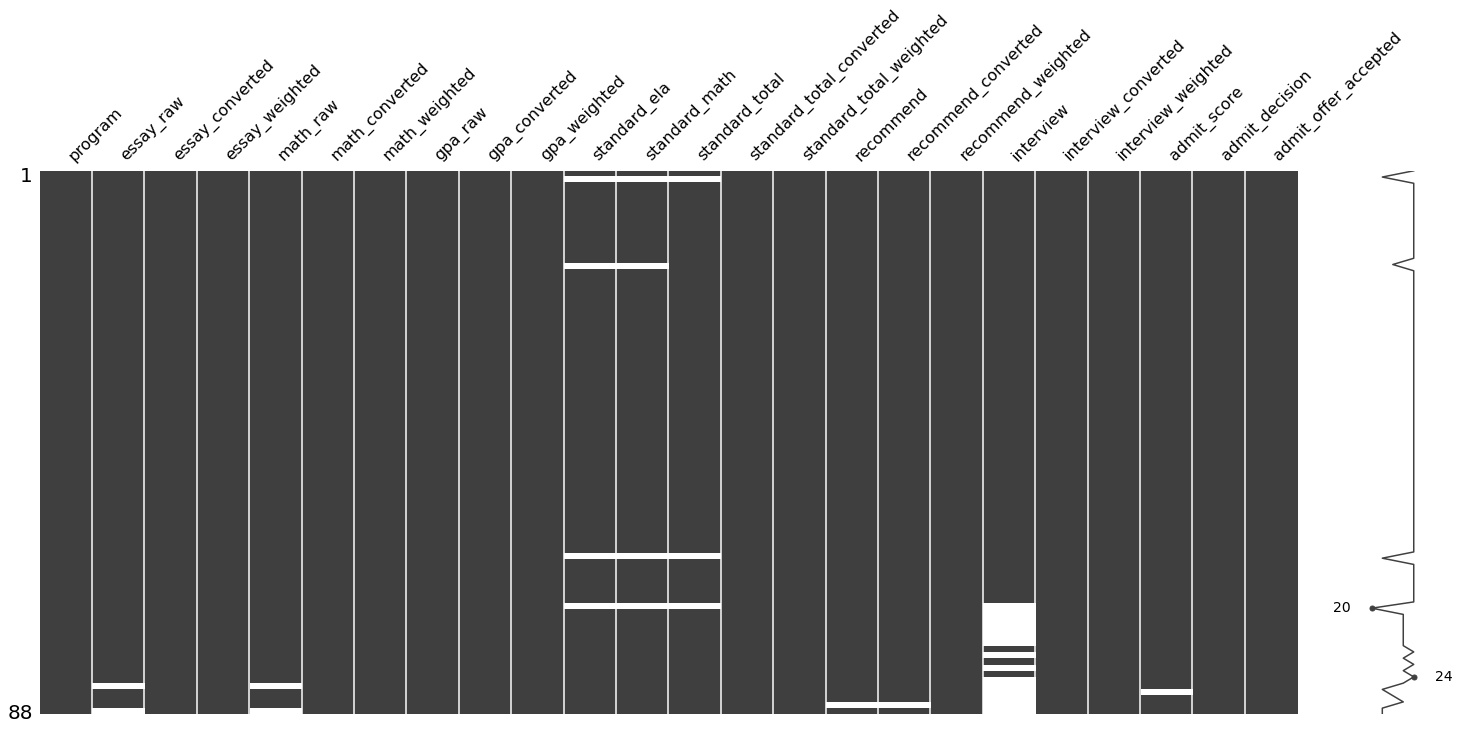

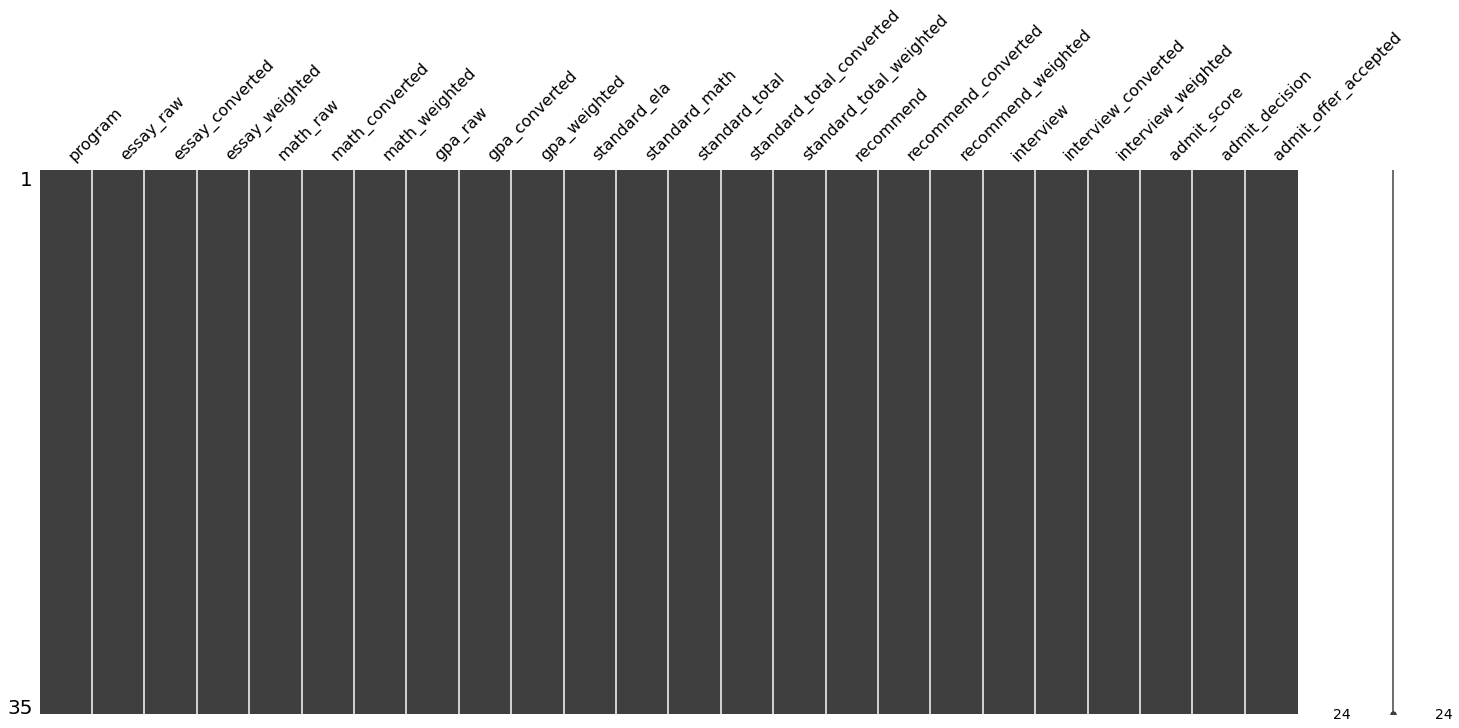

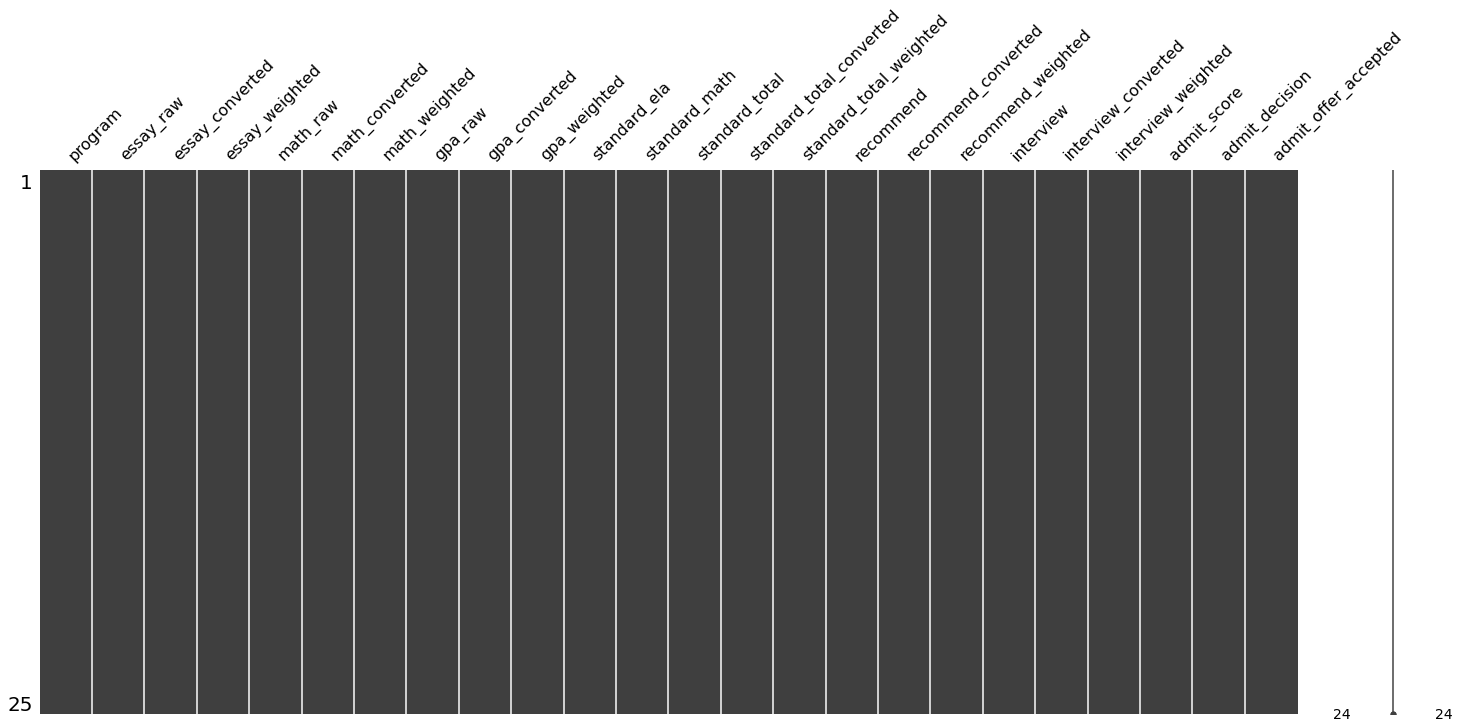

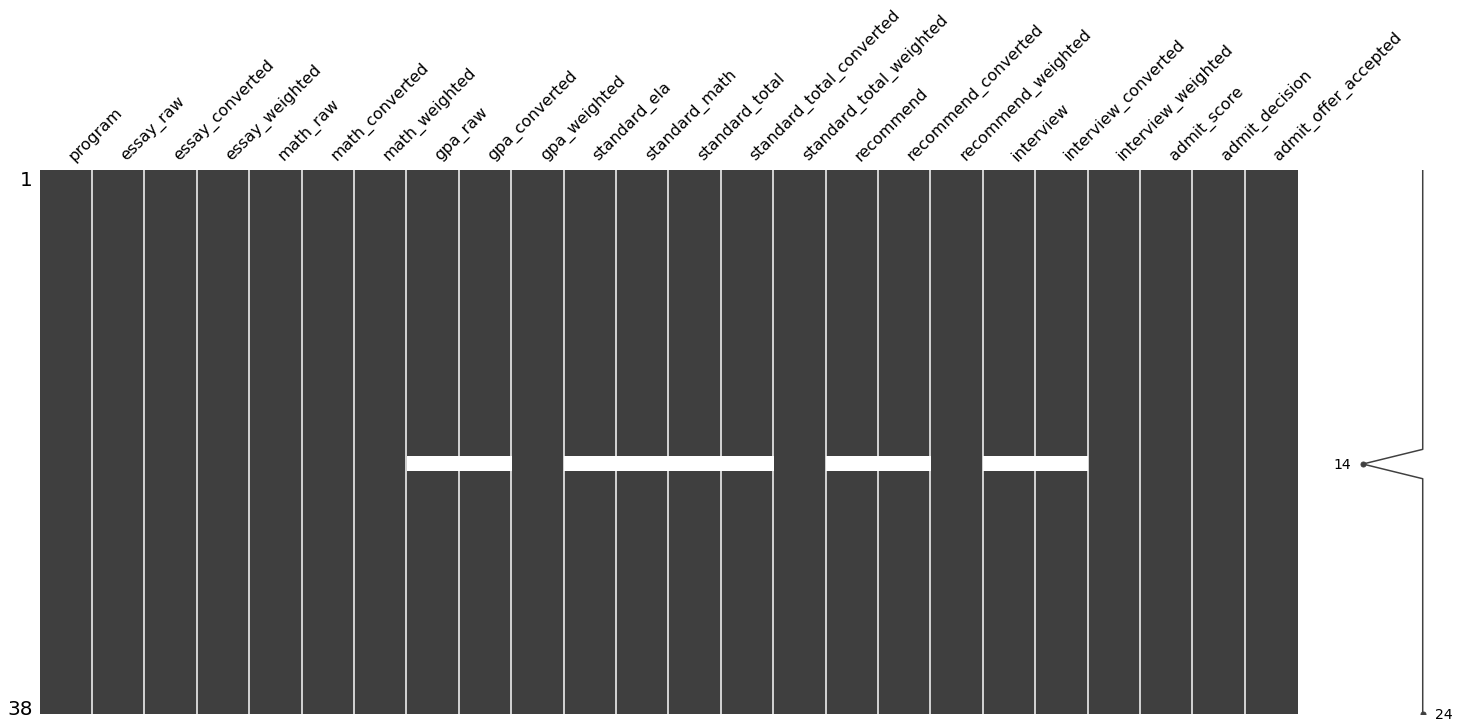

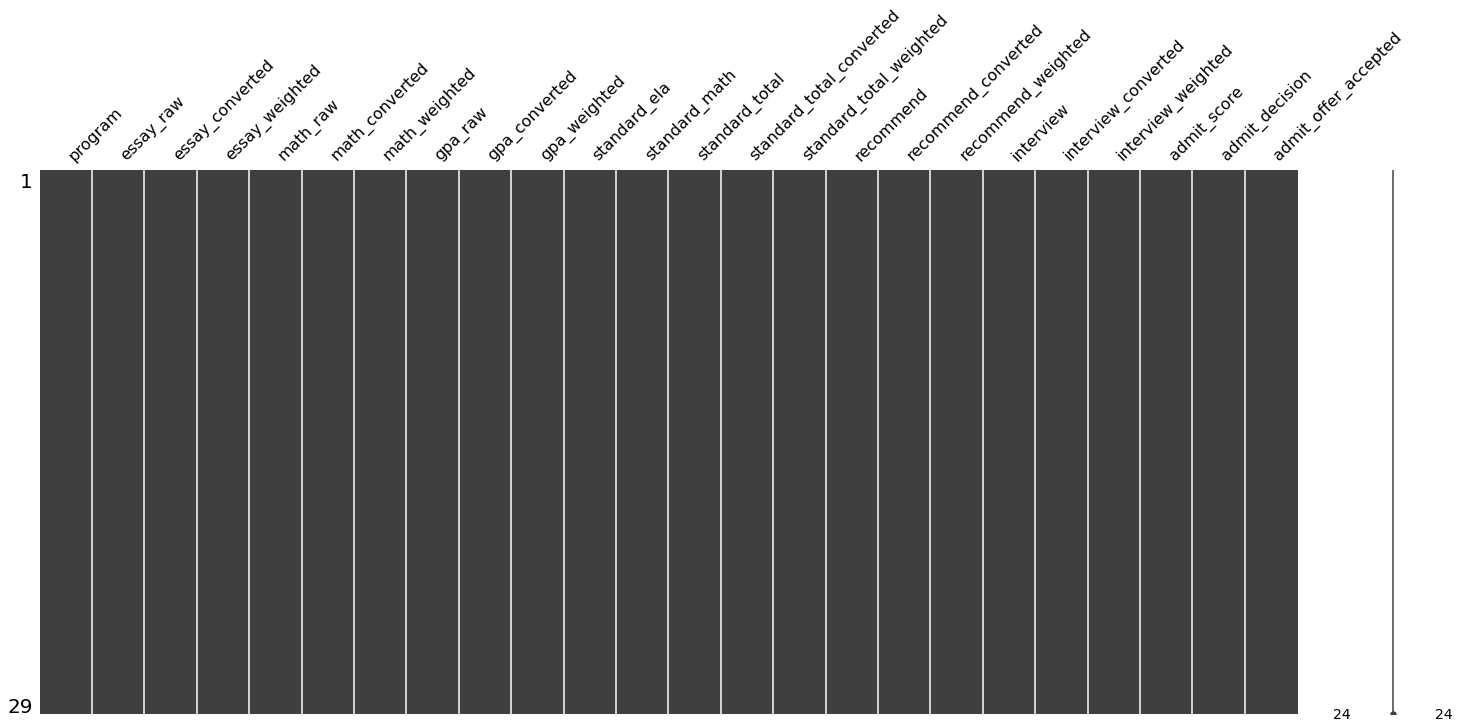

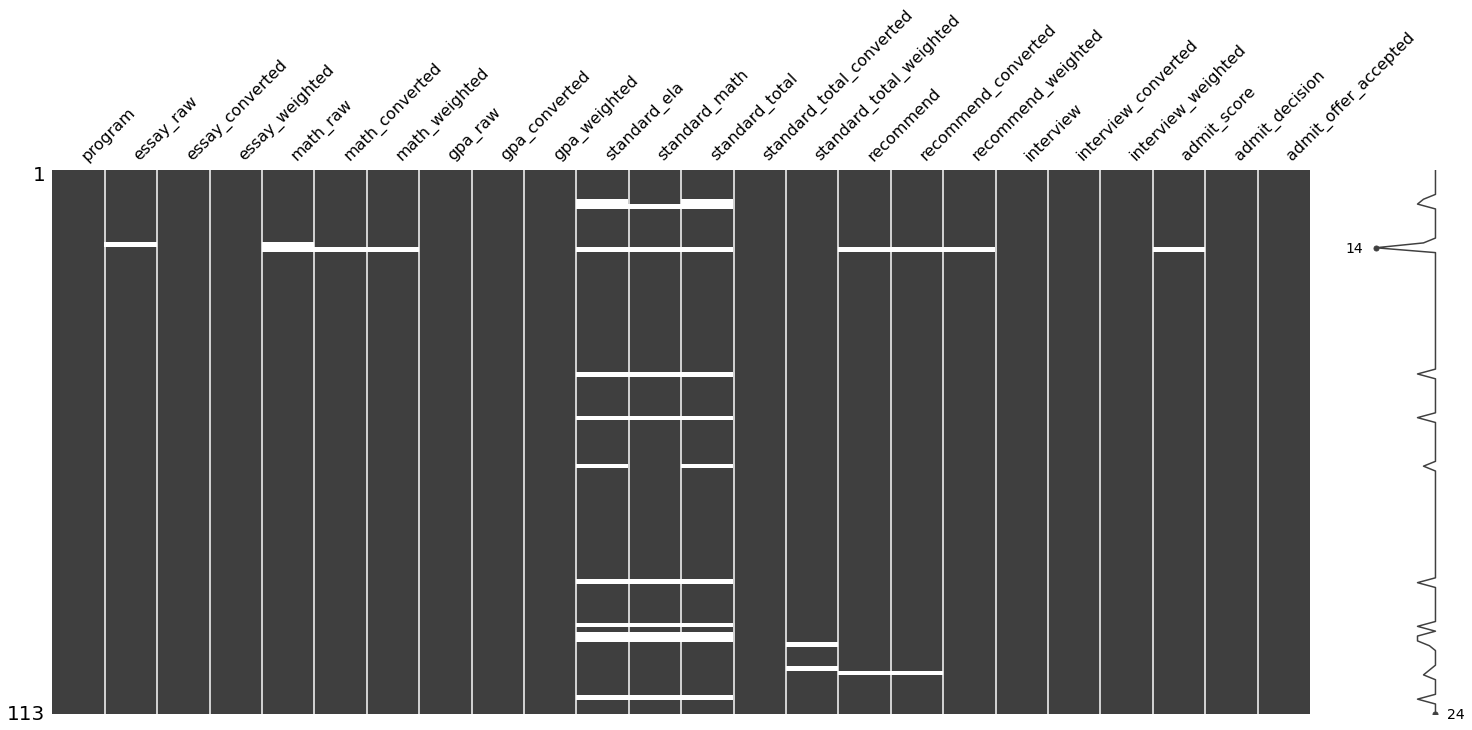

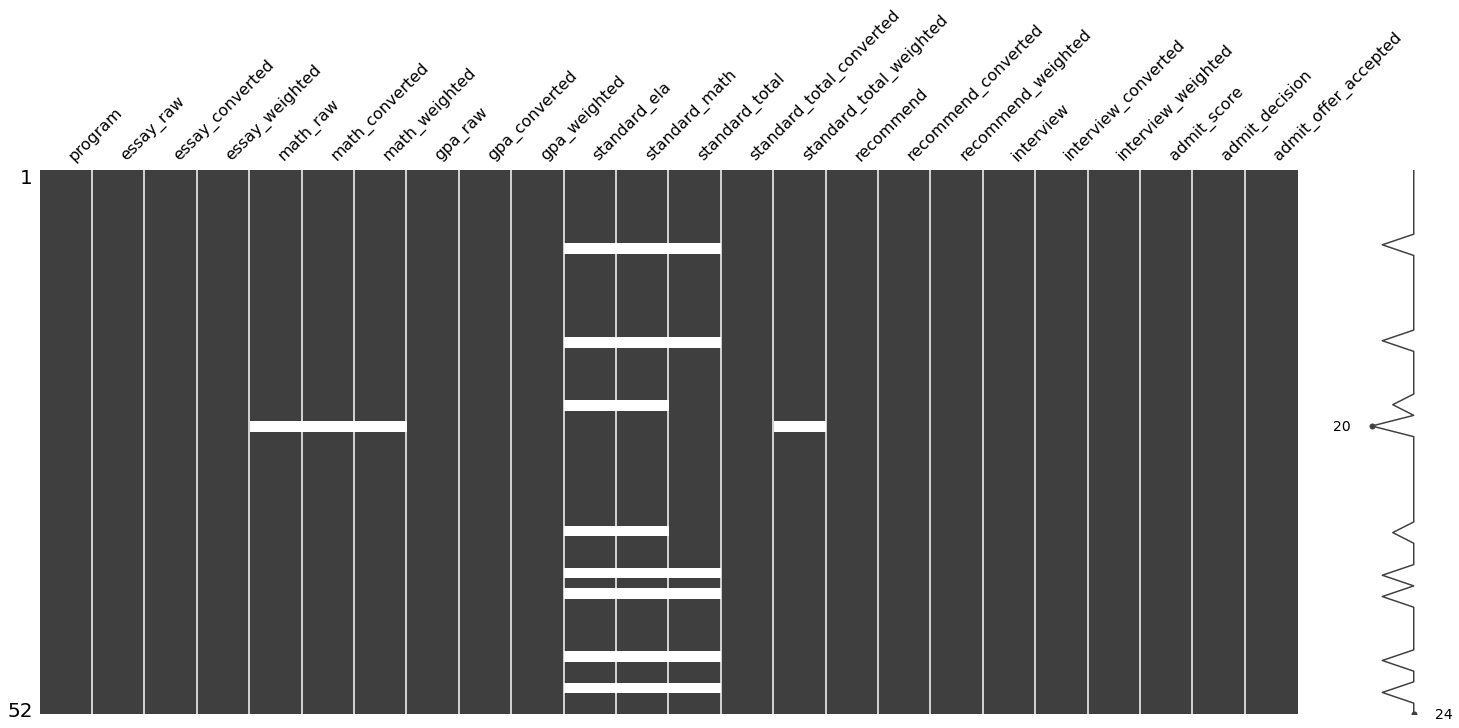

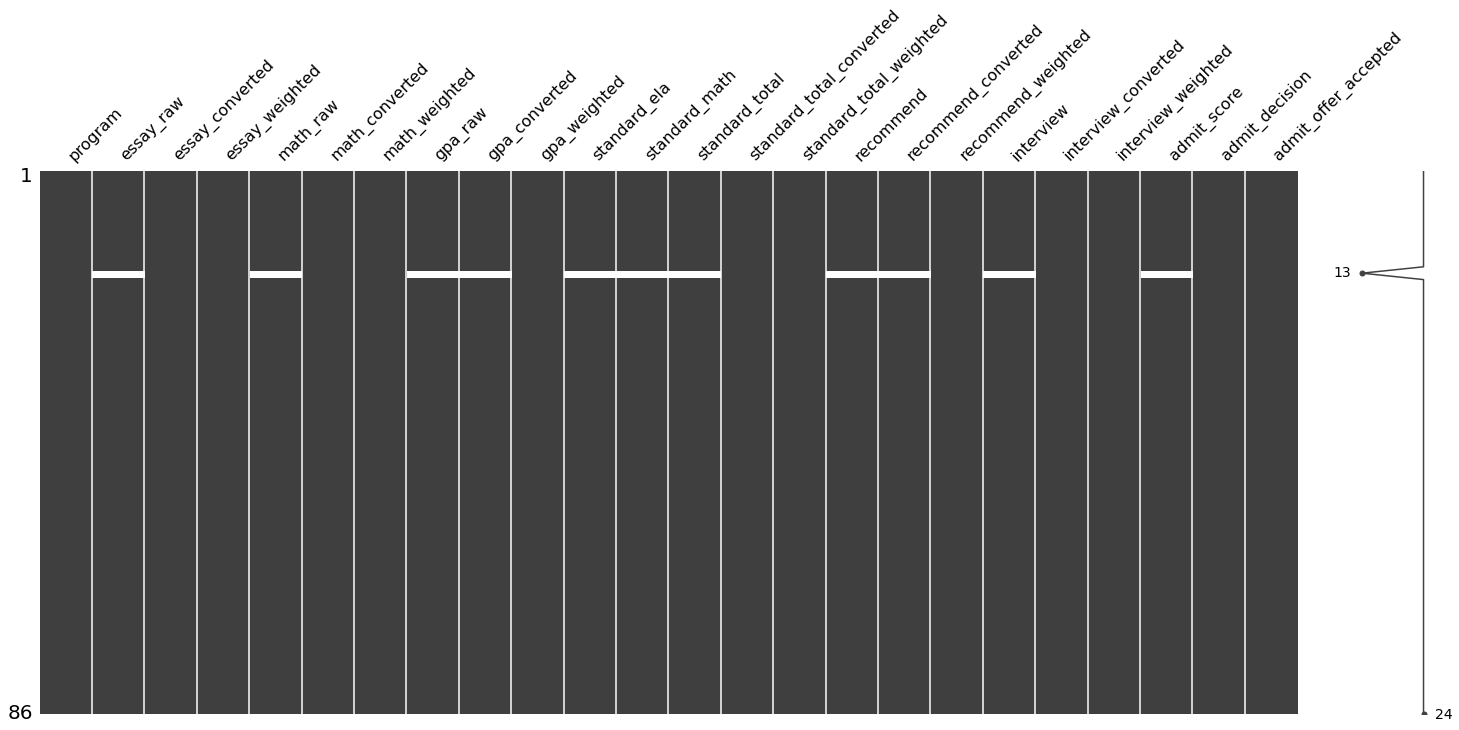

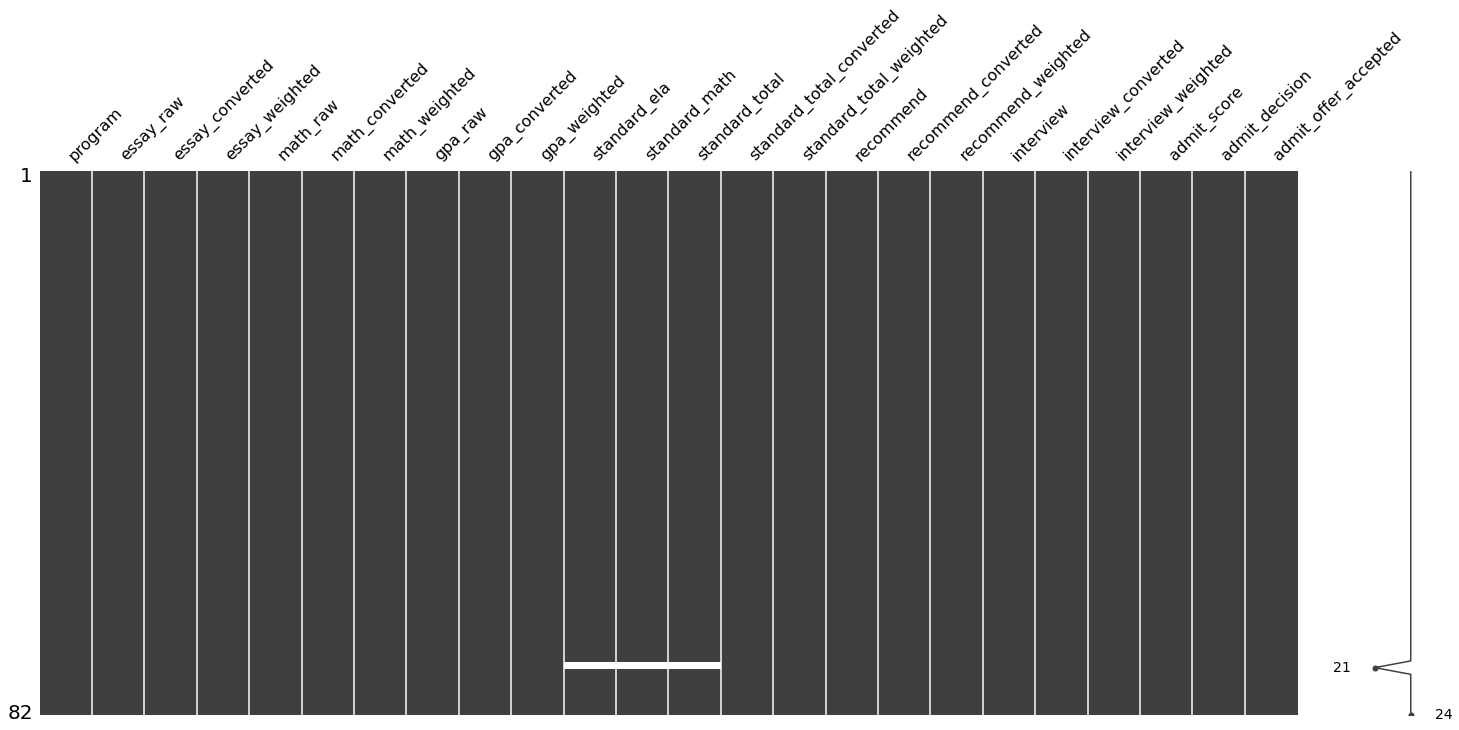

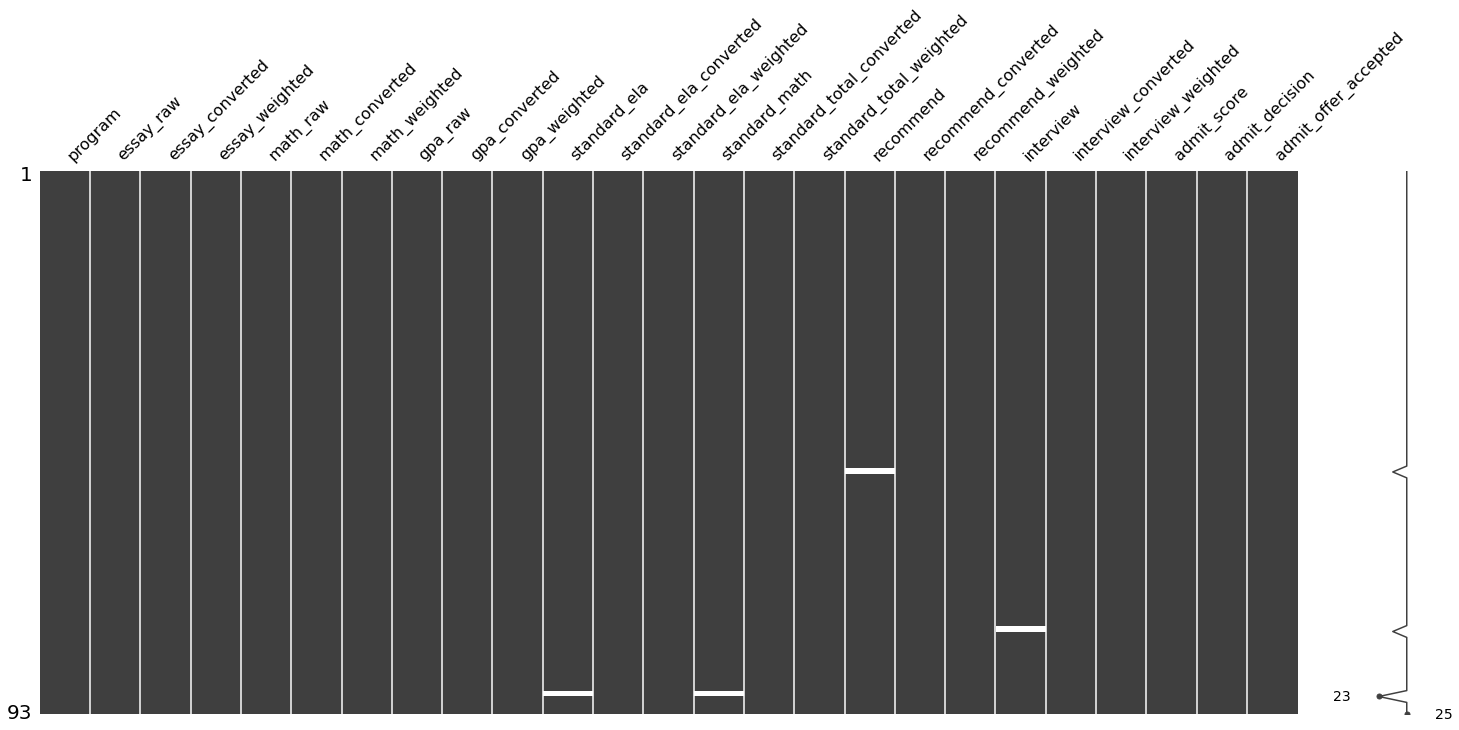

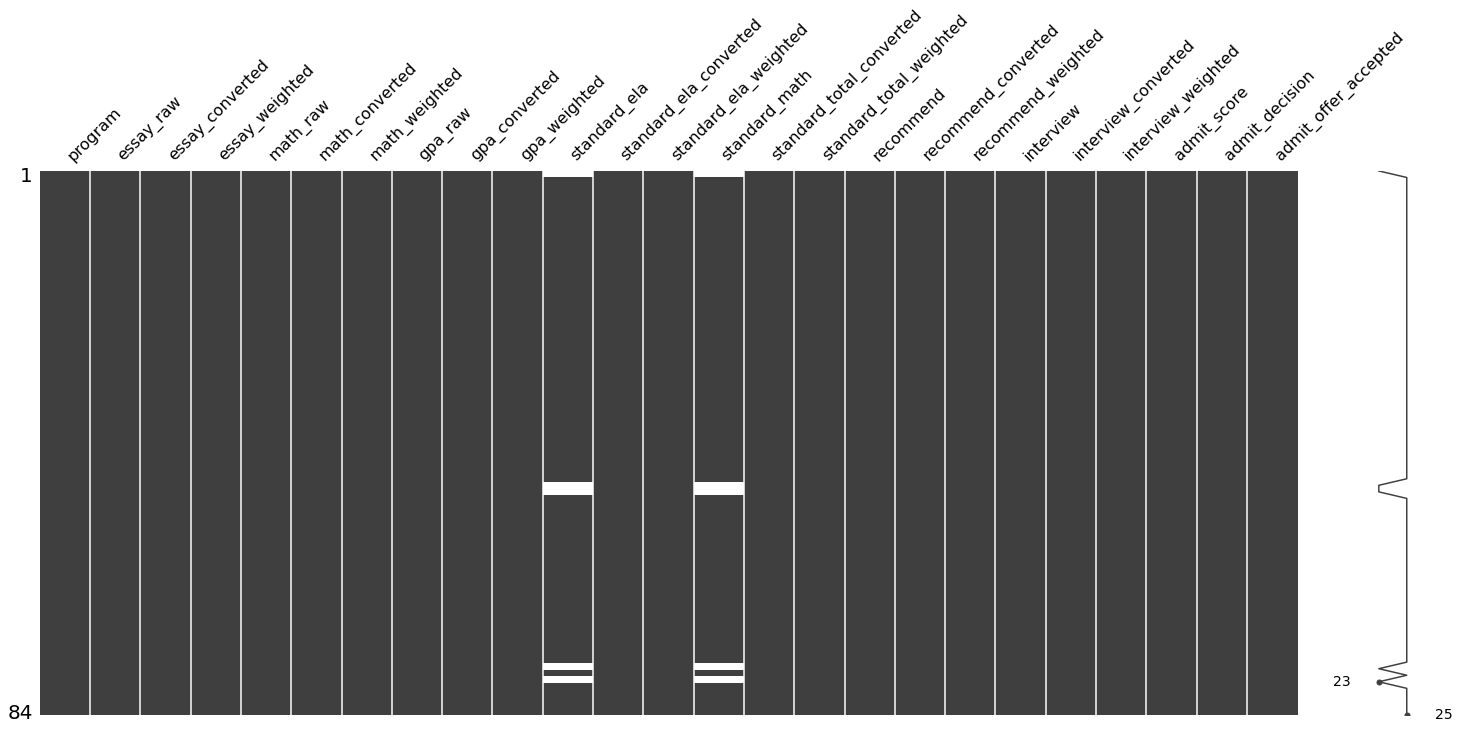

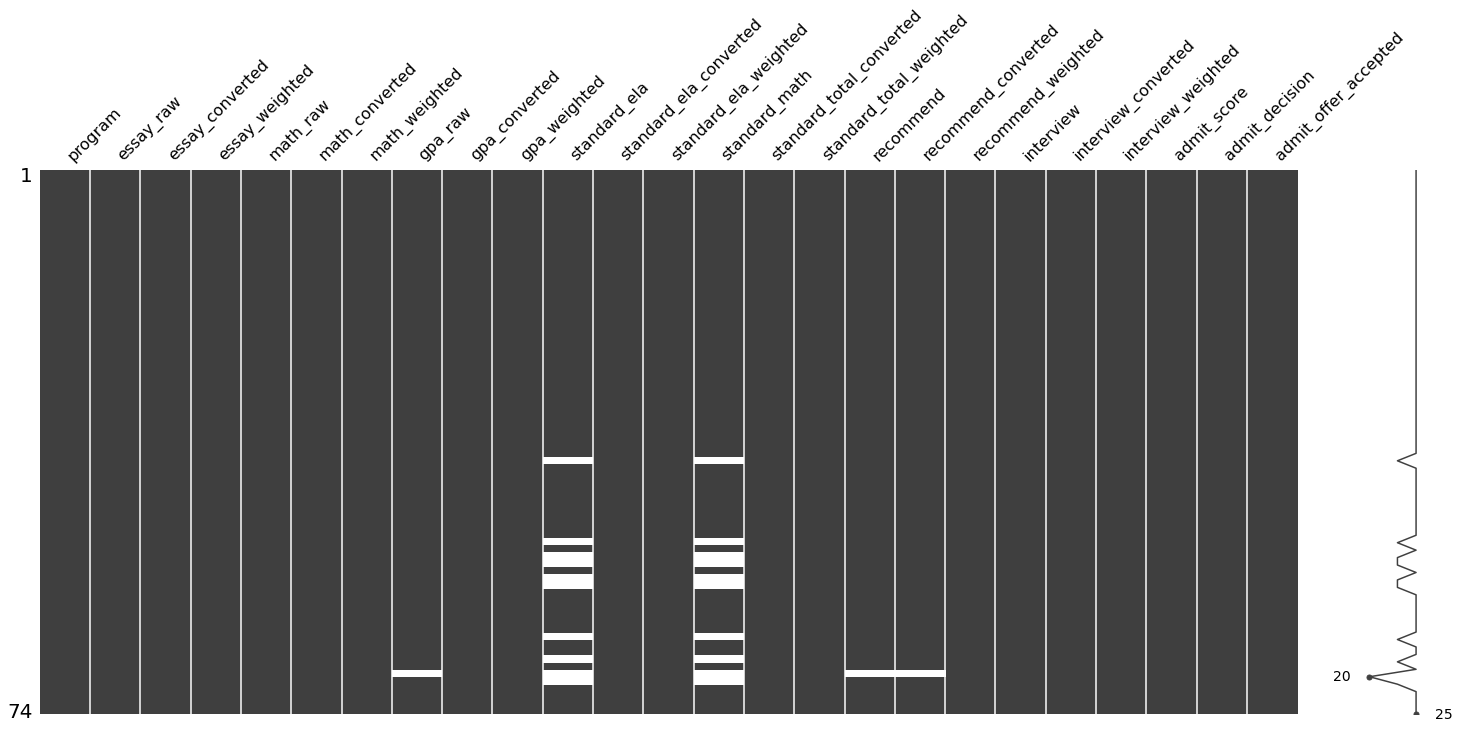

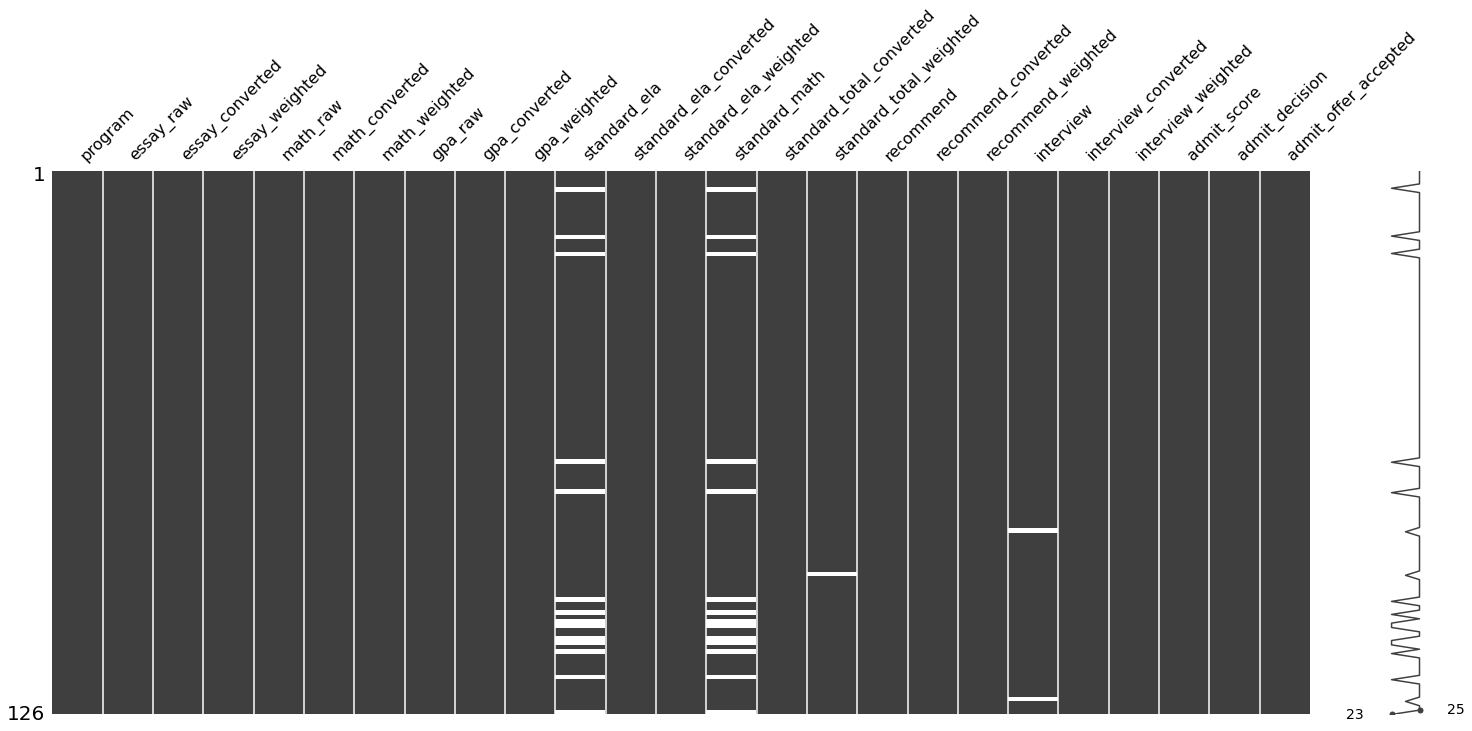

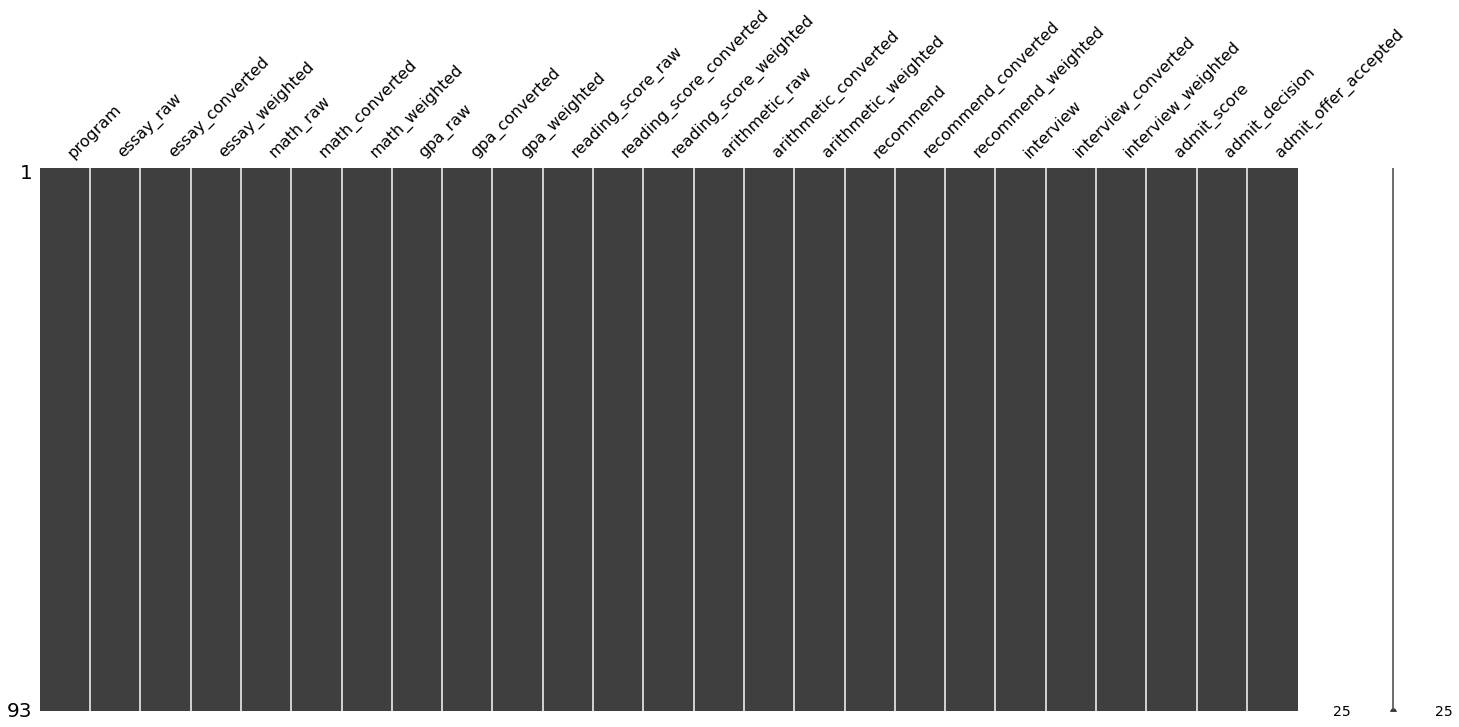

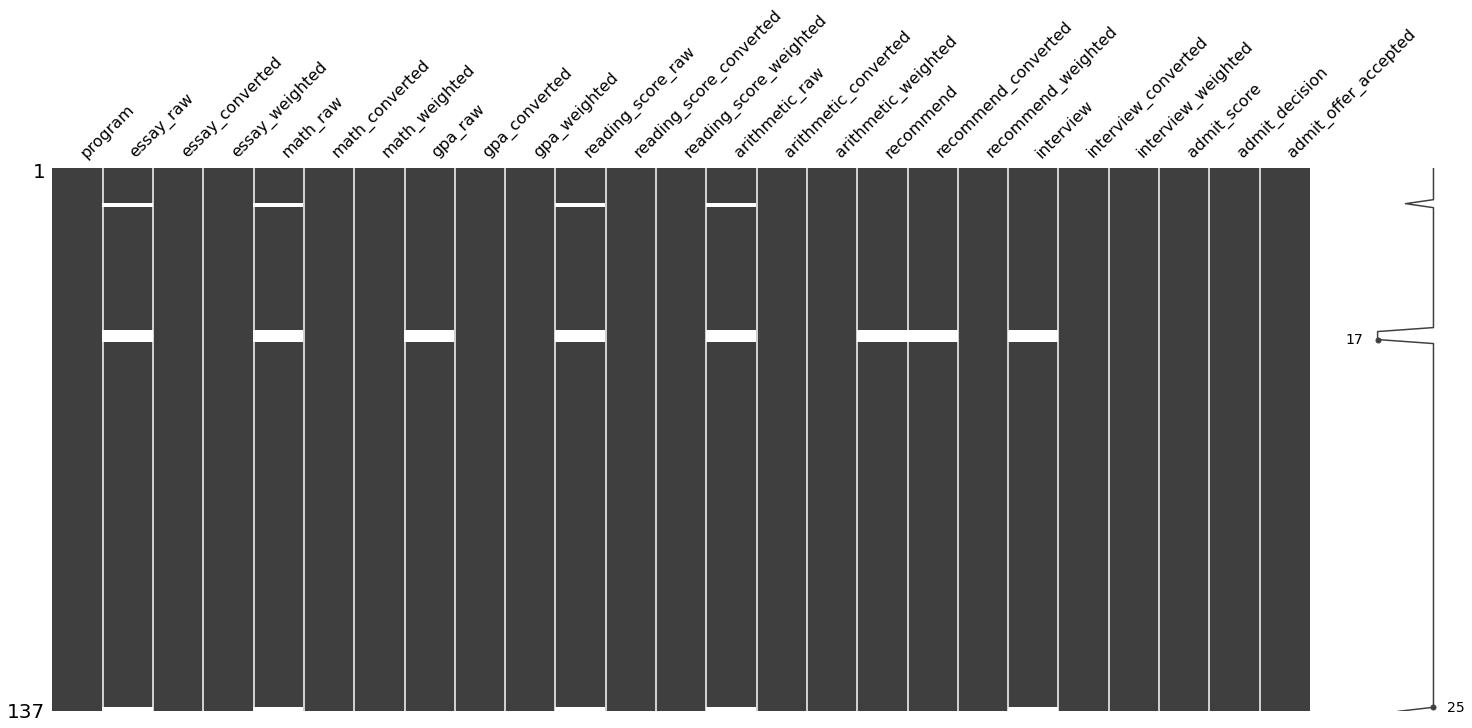

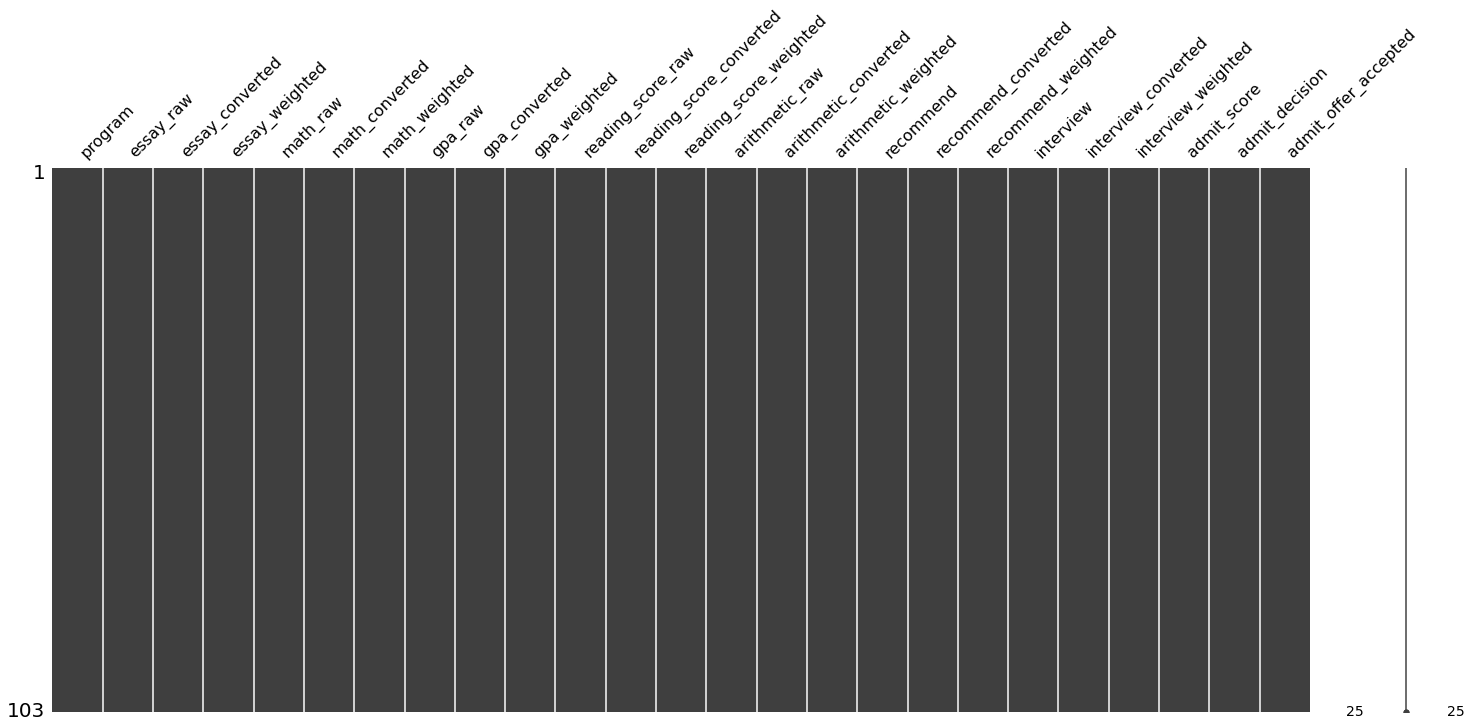

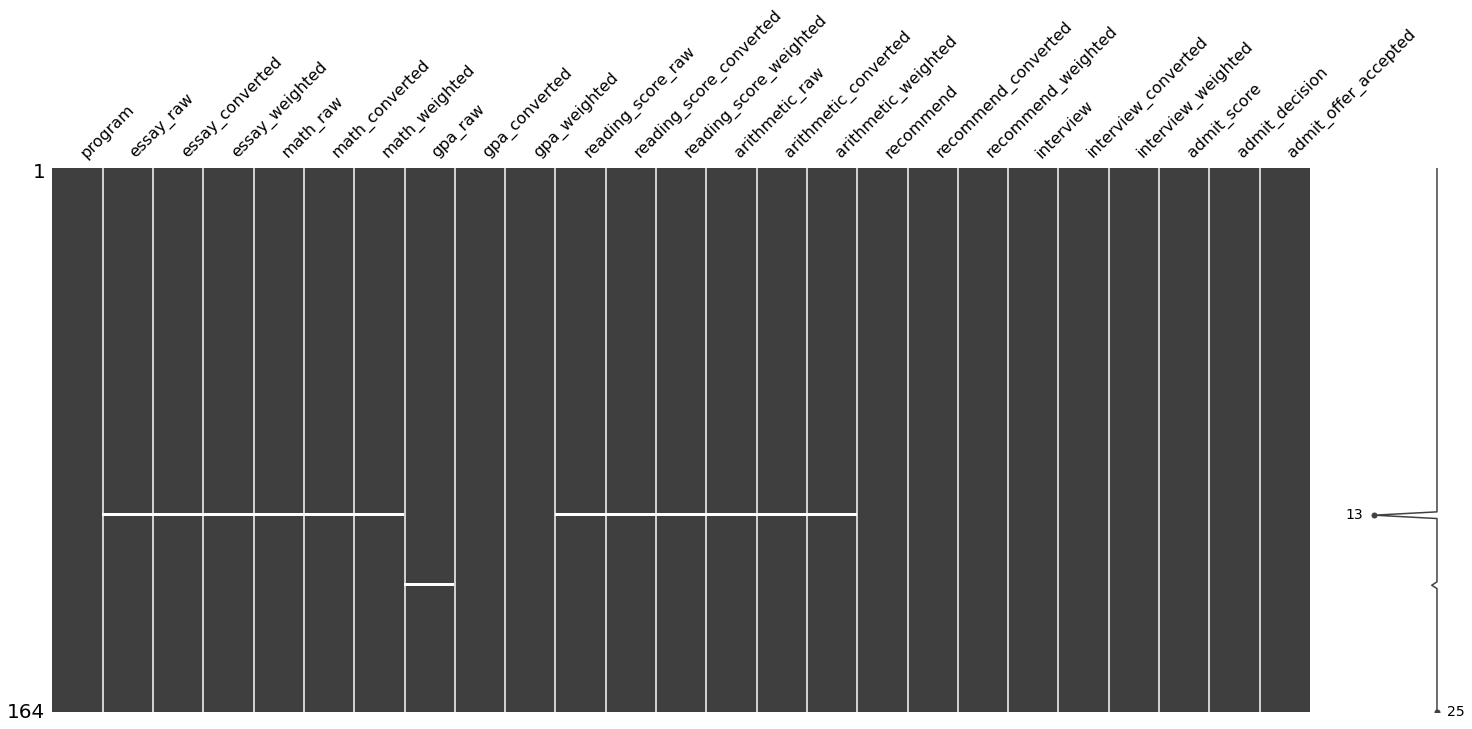

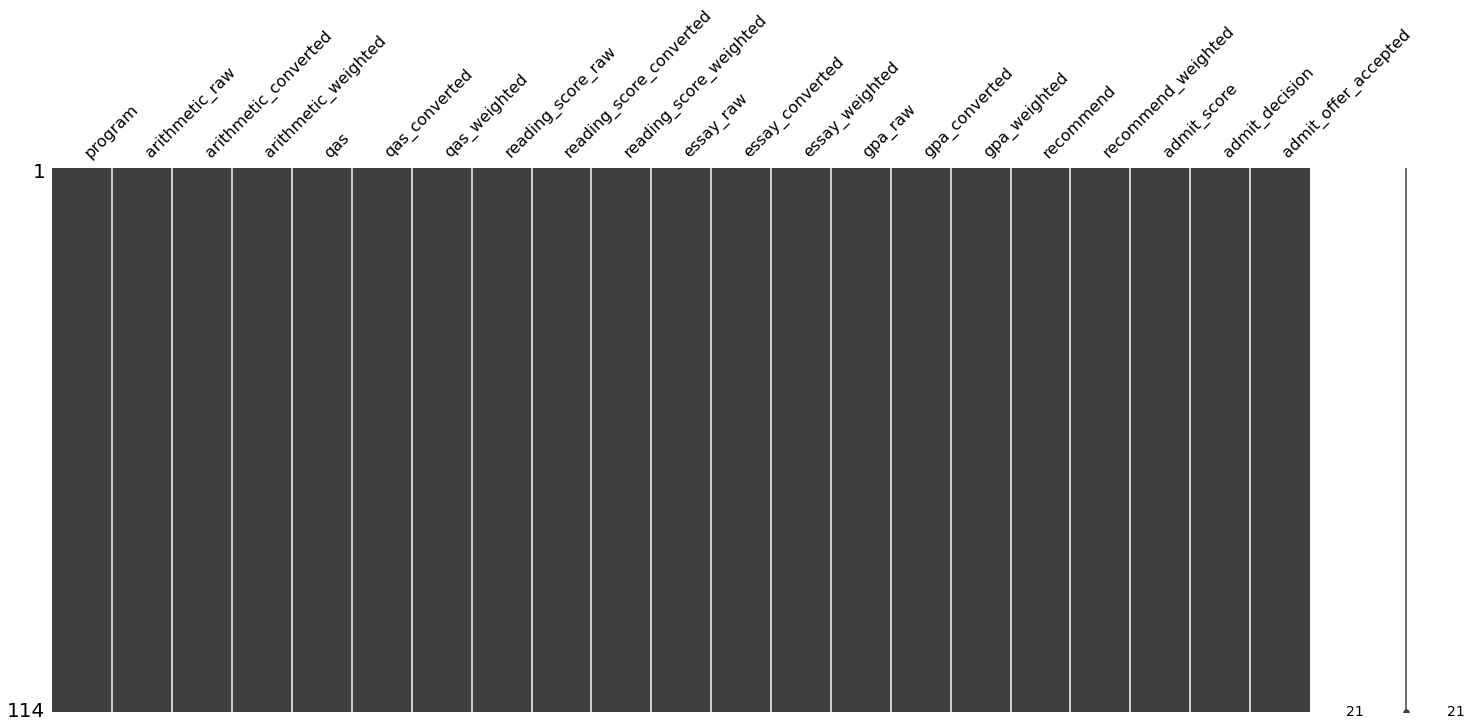

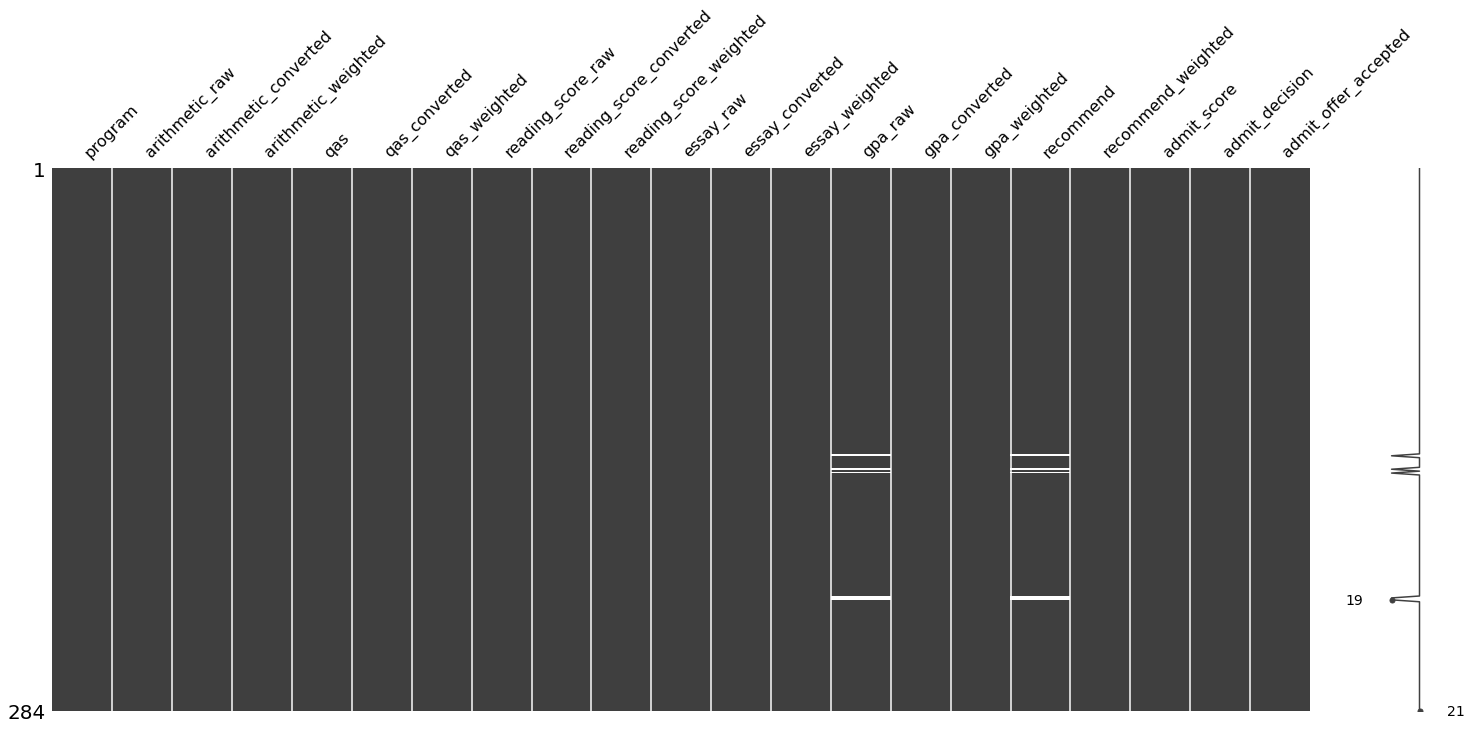

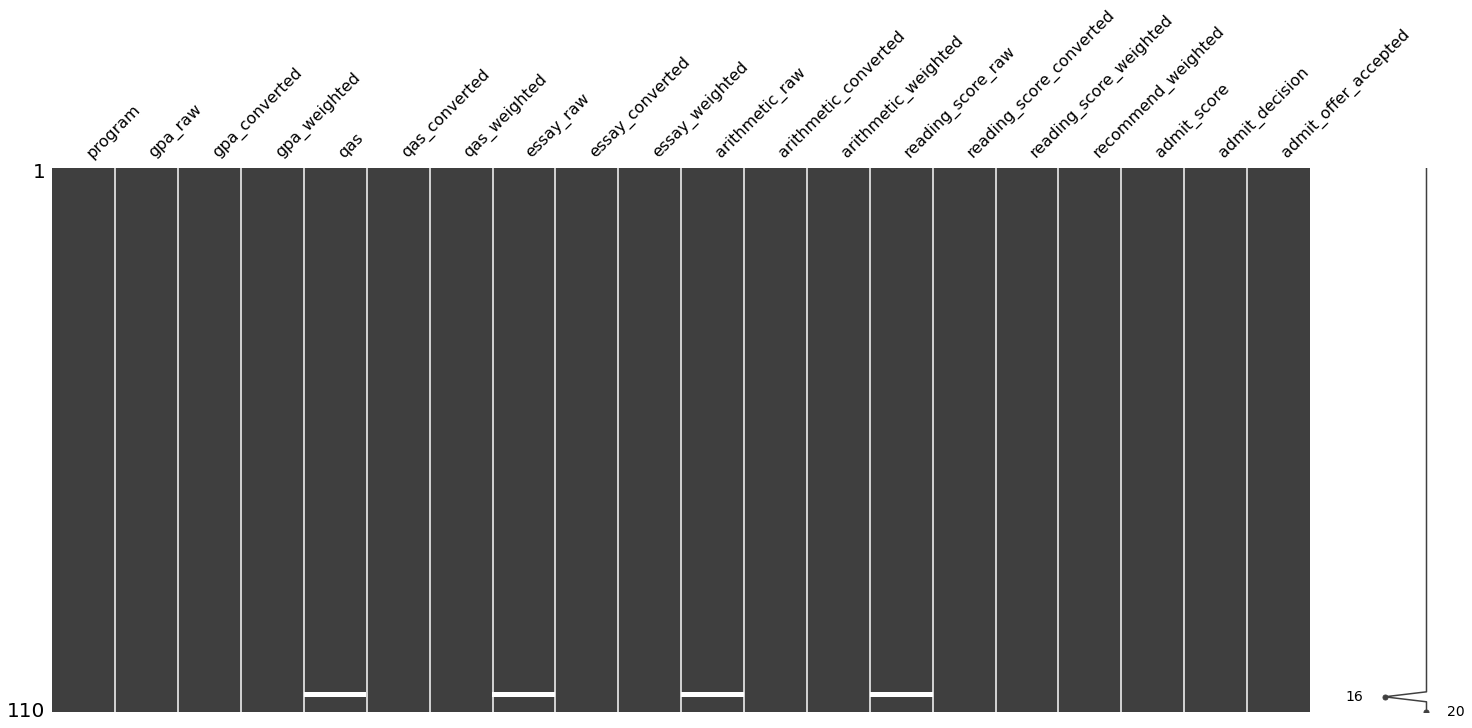

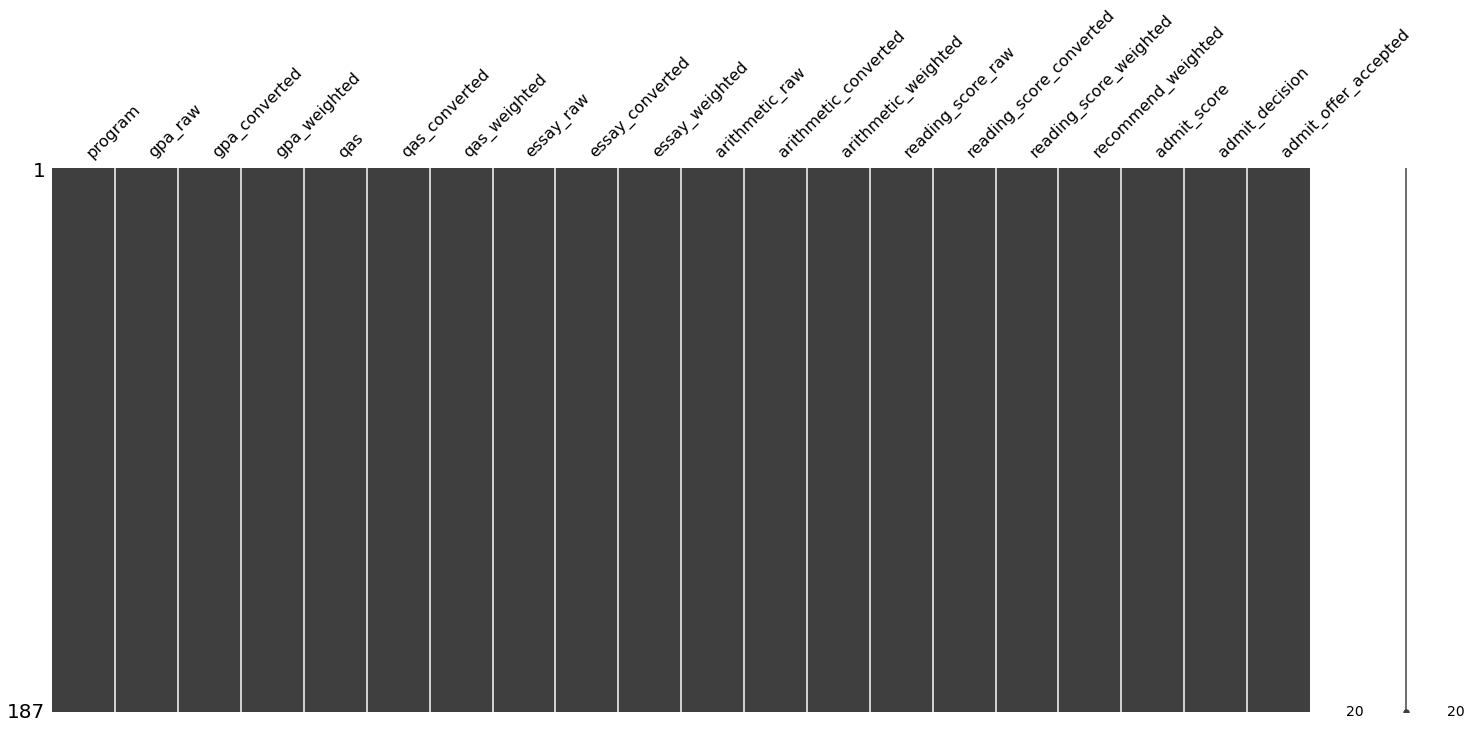

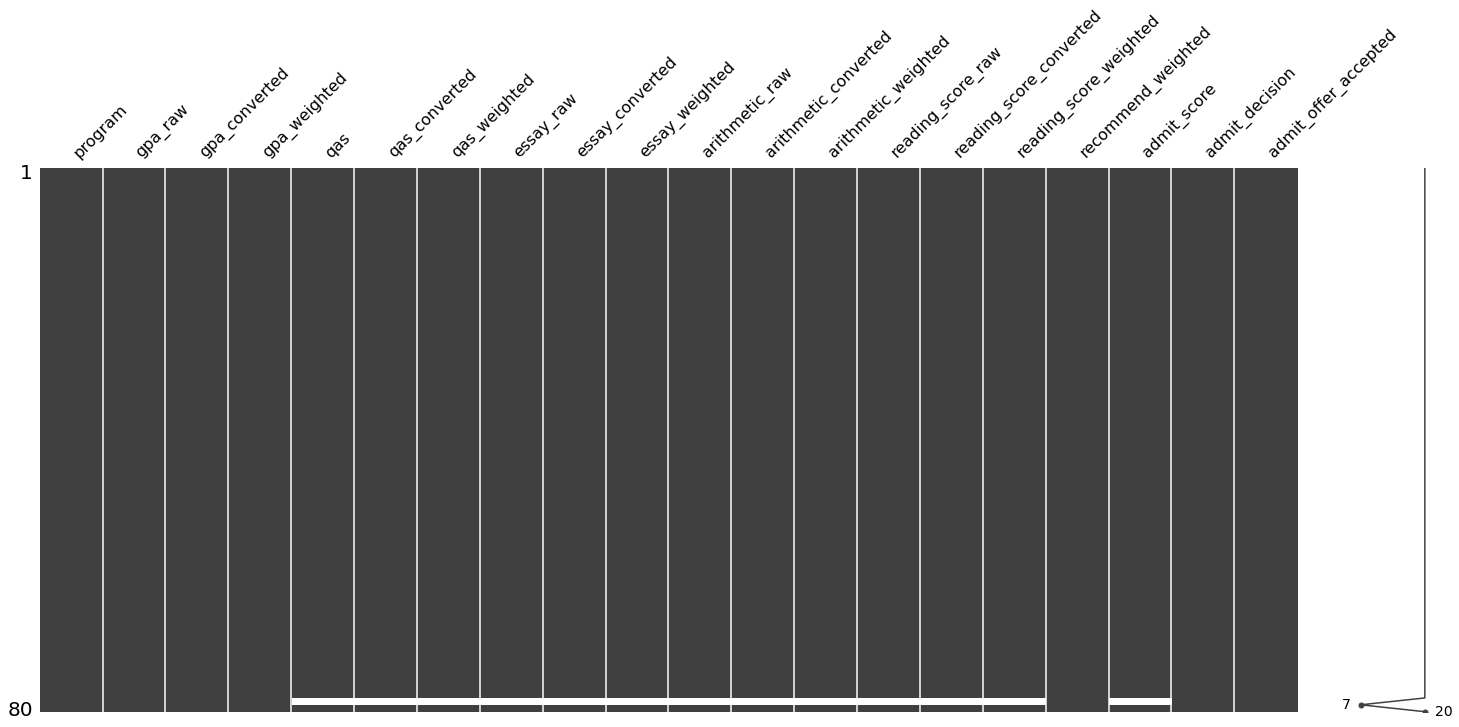

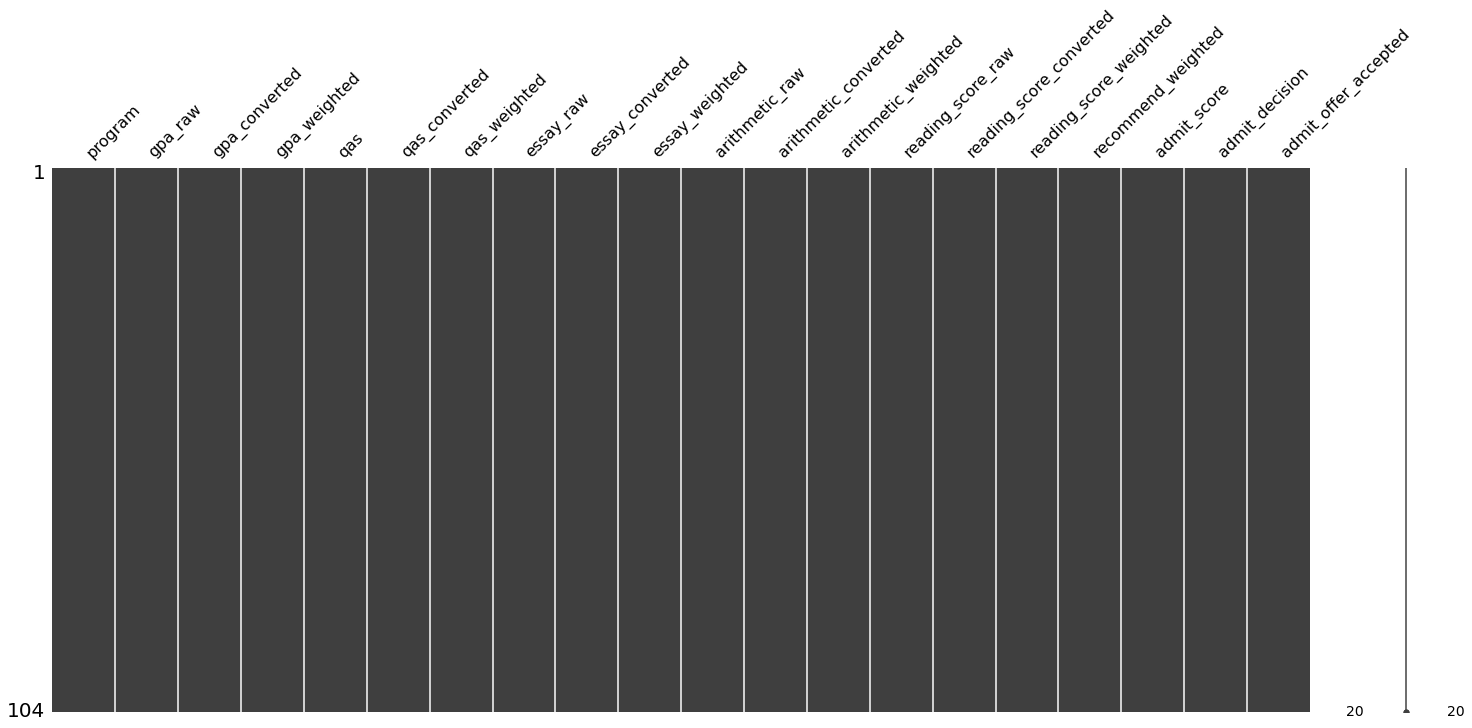

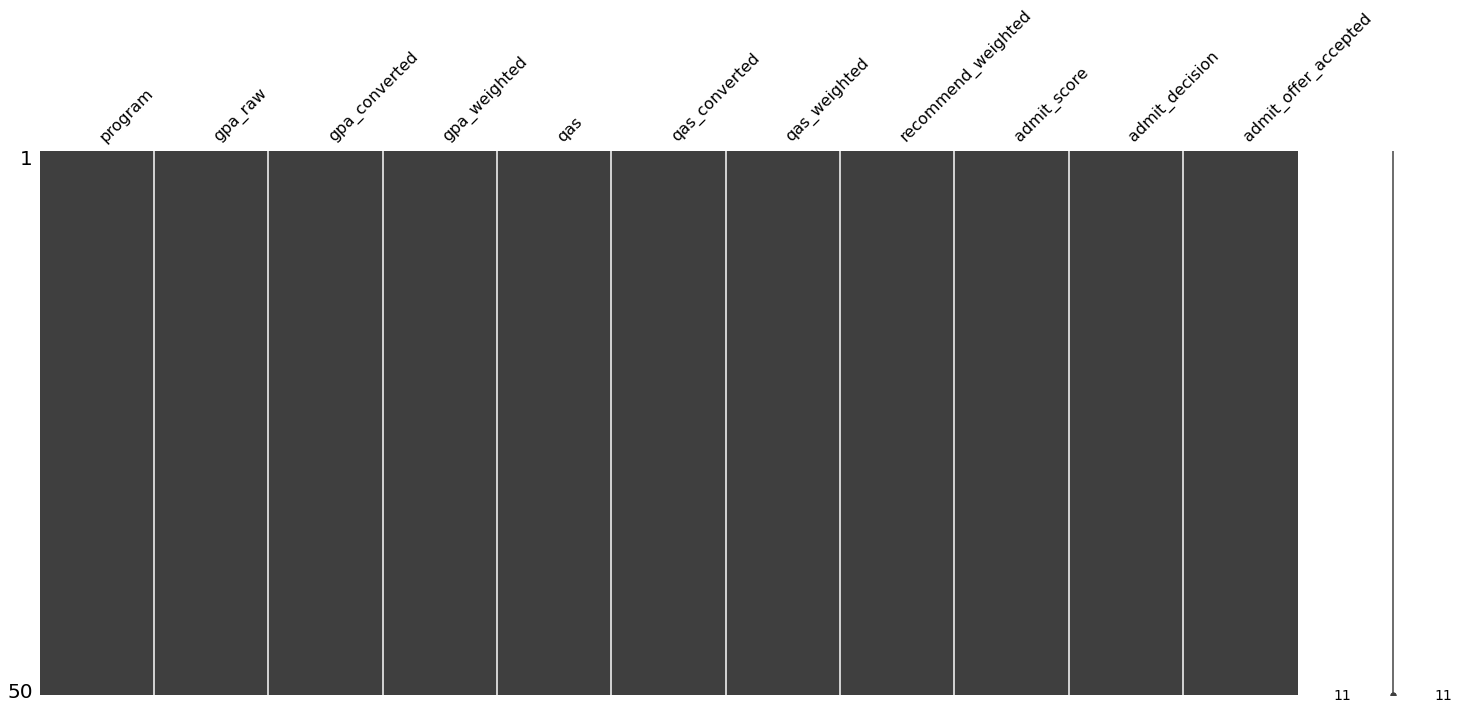

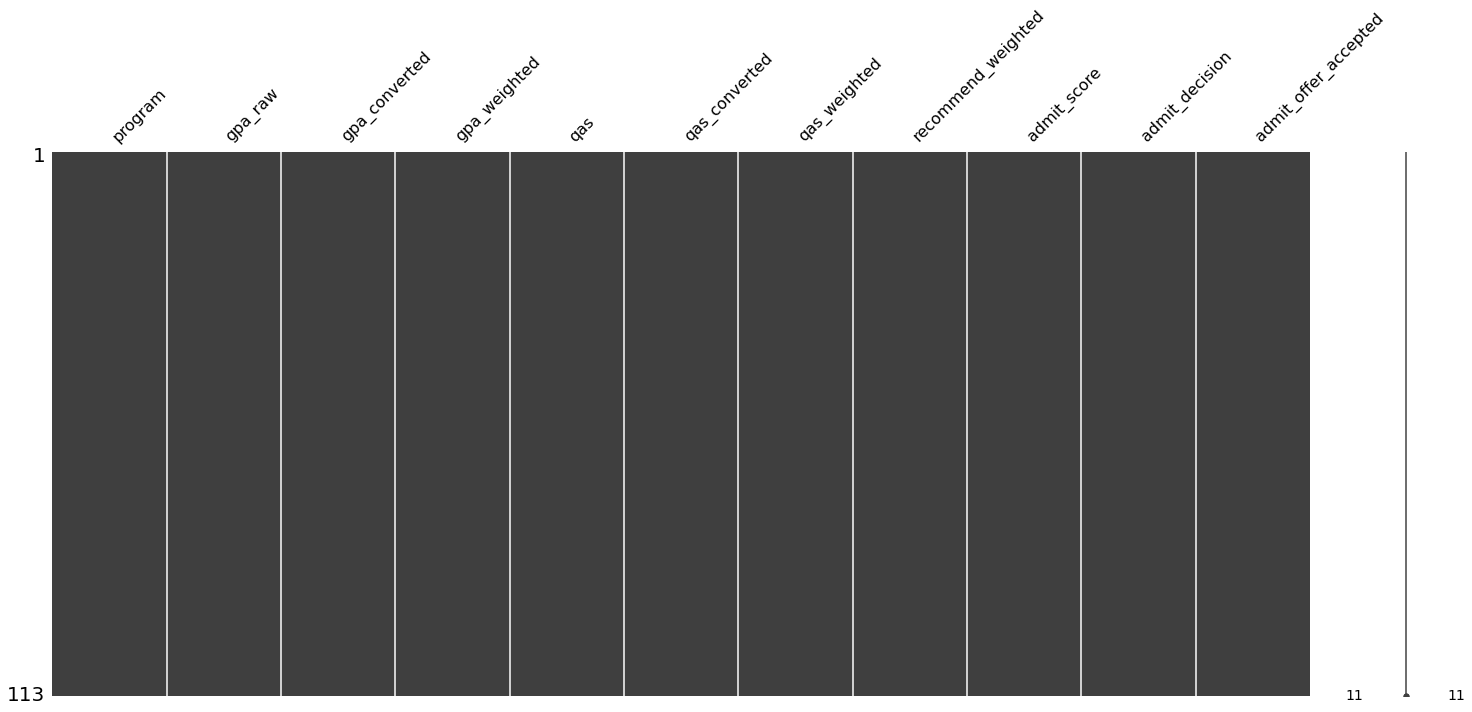

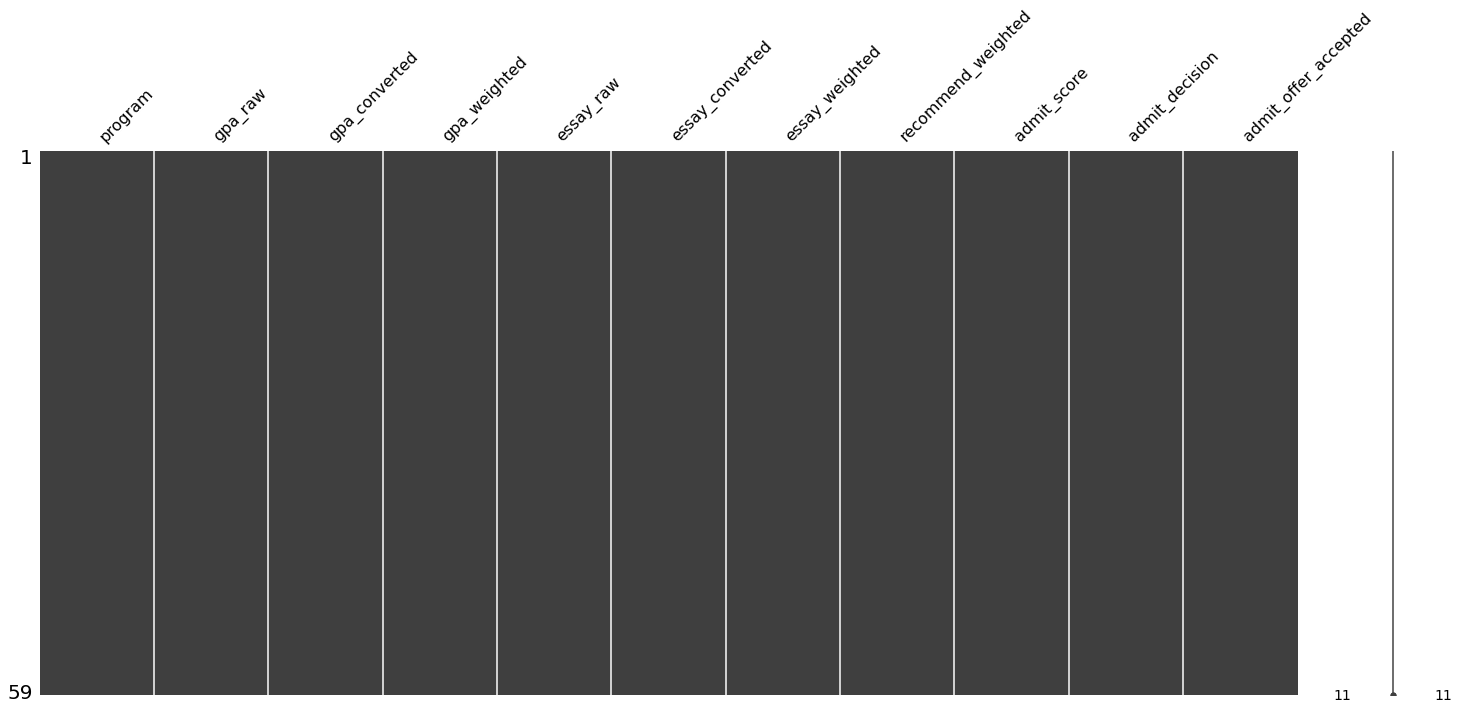

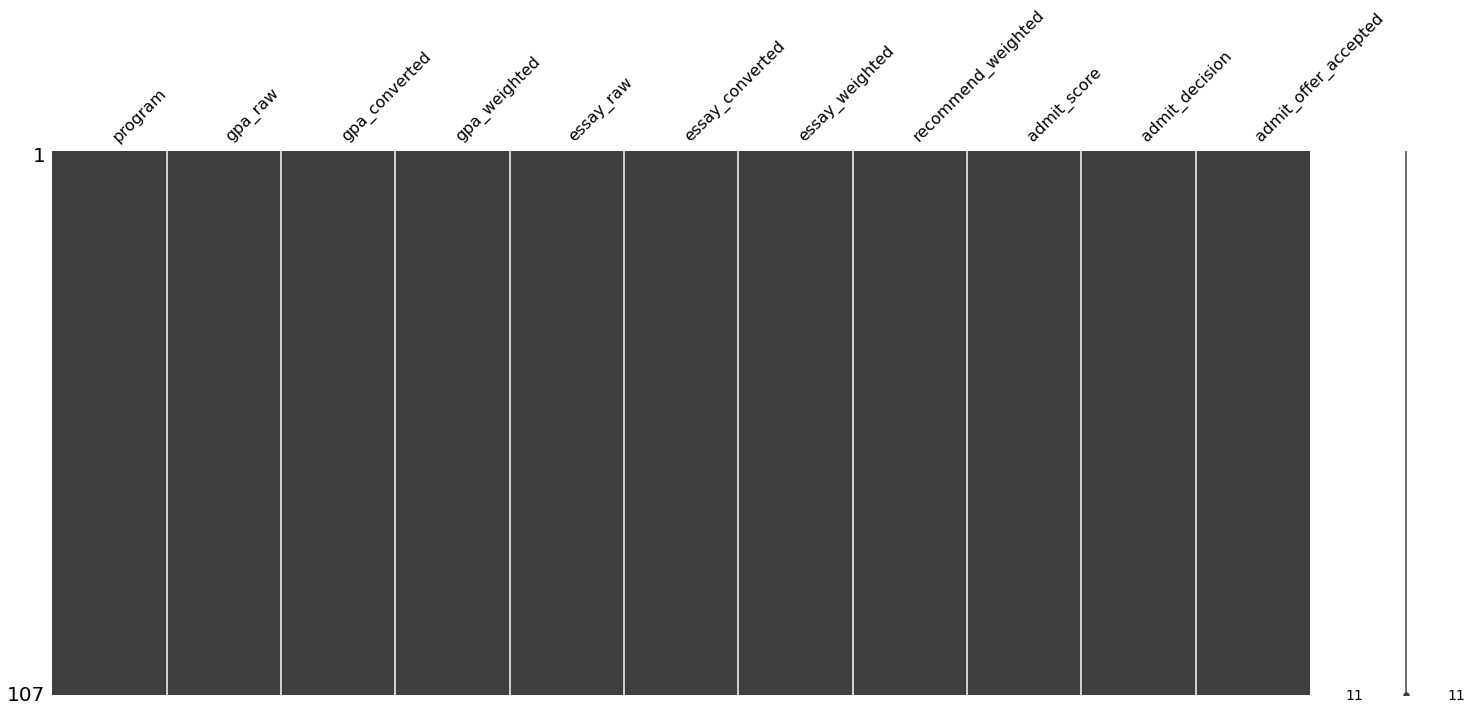

In [23]:
'''Visualize missing data'''
for key,item in var_dict.items():
    msno.matrix(item.sort_values('admit_decision'))

Given the low rate and nature of missingness, we are going to utilize MissForest imputation to fill missing values.  However, in order to prevent data leakage, this will be conducted within a pipeline when we are ready to build our model.

### In the following cells, the missing data in each dataframe will be imputed and standardized separately. This will be done since different dependent measures were utilized across years.  Each year will be imputed and standarized separately and then the dataframes will be concatanated.

In [24]:
'''Pickle datafile'''
with open('mib_cleaned_data.pkl', 'wb') as f:
    pickle.dump(var_dict, f)

In [25]:
'''Open pickled file'''
with open('mib_cleaned_data.pkl', 'rb') as f:
    var_dict = pickle.load(f)

In [30]:
for key,item in var_dict.items():
    item['student_category'] = item['program'].astype('object') + '-' + item['admit_decision'].astype('object') + '-' +\
                                item['admit_offer_accepted'].astype('object')

    item['student_category'] = item['student_category'].astype('category')
    print(item)

   program  essay_raw  essay_converted  essay_weighted  math_raw  \
0   Magnet        4.5             75.0             4.5      27.0   
1   Magnet        5.0             80.0             4.8      36.0   
2   Magnet        5.0             80.0             4.8      88.0   
3   Magnet        5.0             80.0             4.8      85.0   
4   Magnet        4.0             70.0             4.2      69.0   
..     ...        ...              ...             ...       ...   
83  Magnet        6.0            100.0             6.0      73.0   
84      IB        4.5             75.0             7.5      53.0   
85  Magnet        4.5             75.0             4.5      53.0   
86      IB        4.5             75.0             7.5      54.0   
87  Magnet        4.5             75.0             4.5      54.0   

    math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0              0.0            0.0     95.0           80.0          16.0  ...   
1              0.0     

    program  arithmetic_raw  arithmetic_converted  arithmetic_weighted    qas  \
0        IB           107.0                  90.0                 13.5  100.0   
1        IB            96.0                  80.0                 12.0   58.0   
2        IB            93.0                  80.0                 12.0   57.0   
3        IB            84.0                  70.0                 10.5   56.0   
4        IB            91.0                  80.0                 12.0   43.0   
..      ...             ...                   ...                  ...    ...   
279  Magnet           104.0                  90.0                 13.5   72.0   
280  Magnet           103.0                  90.0                 13.5   77.0   
281  Magnet           116.0                 100.0                 15.0   45.0   
282  Magnet            93.0                  80.0                 12.0   48.0   
283  Magnet            81.0                  70.0                 10.5   42.0   

     qas_converted  qas_wei

In [ ]:
'''Standardize columns across dataframes----NOT USED'''
'''column_list_complete = []
for key, item in var_dict.items():
    for column in item.columns.to_list():
        if column not in column_list_complete:
            column_list_complete.append(column)

for key, item in var_dict.items():
    difference_columns = [column for column in column_list_complete if column not in item.columns]
    for column in difference_columns:
        item[column] = np.nan
    print(key, item)        '''

In [31]:
'''Transformer for numerical features'''
num_pipe = Pipeline(
    [
        ('imputer_num', KNNImputer()),
        ('scaler', StandardScaler())
    ]
)

In [32]:
'''Transformer for categorical features'''
cat_pipe = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False)) 
    ]
)

In [34]:
for key,item in var_dict.items():
    df = (var_dict[key])
    print(key)
    num_cols = select_numeric(df)
    #print('num_cols:', num_cols, '\n')
    cat_cols = select_categorical(df)
    if 'program' not in cat_cols:
        X=df
        print('program_no', X.columns, len(X.columns))
    if 'program' in cat_cols:
        cat_cols.remove('program')
        print('cat_cols:', cat_cols, '\n')
        X = df.drop('program', axis = 1)
        print('program_yes', X.columns, len(X.columns))

    num_cols = select_numeric(item)
    print(num_cols)
    cat_cols = select_categorical(item)
    cat_cols.remove('program')
    print (cat_cols)        
        
    '''Combine transformers into ColumnTransformer'''
    preprocessor = ColumnTransformer(
        [
            ('categorical', cat_pipe, cat_cols),
            ('numerical', num_pipe, num_cols)
        ],
        remainder = 'passthrough',
    )

    
    '''Fit Model'''
    print('X-columns:', X.columns, len(X.columns), '\n')
    preprocessor.fit(X)

    '''Prepare column names'''
    cat_columns = preprocessor.named_transformers_['categorical']['one_hot'].get_feature_names_out(cat_cols)
    print('cat_columns:', cat_columns, len(cat_columns), '\n')
    print('num_columns:', num_cols, len(num_cols), '\n')
    columns = np.append(cat_columns, num_cols)
    print('columns:', columns, len(columns), '\n')

    
    preprocess_trans = preprocessor.transform(X)
    preprocess_trans_cols = preprocessor.named_transformers_['categorical']['one_hot'].get_feature_names_out(cat_cols)
    print(preprocess_trans_cols, len(preprocess_trans_cols))
    print(preprocess_trans[0], len(preprocess_trans[0]))
    df_trans = pd.DataFrame(preprocessor.transform(X), columns = columns)
    var_dict[key] = df_trans
    cat_cols = []
    num_cols = []
    columns = []

df_2008_2009_ib_magnet
cat_cols: ['admit_decision', 'admit_offer_accepted', 'student_category'] 

program_yes Index(['essay_raw', 'essay_converted', 'essay_weighted', 'math_raw',
       'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted',
       'gpa_weighted', 'standard_ela', 'standard_math', 'standard_total',
       'standard_total_converted', 'standard_total_weighted', 'recommend',
       'recommend_converted', 'recommend_weighted', 'interview',
       'interview_converted', 'interview_weighted', 'admit_score',
       'admit_decision', 'admit_offer_accepted', 'student_category'],
      dtype='object') 24
['essay_raw', 'essay_converted', 'essay_weighted', 'math_raw', 'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted', 'gpa_weighted', 'standard_ela', 'standard_math', 'standard_total', 'standard_total_converted', 'standard_total_weighted', 'recommend', 'recommend_converted', 'recommend_weighted', 'interview', 'interview_converted', 'interview_weighted', 'admit_scor

cat_columns: ['admit_decision_ax' 'admit_decision_rj' 'admit_offer_accepted_no'
 'admit_offer_accepted_yes' 'student_category_Magnet-ax-no'
 'student_category_Magnet-ax-yes' 'student_category_Magnet-rj-no'] 7 

num_columns: ['essay_raw', 'essay_converted', 'essay_weighted', 'math_raw', 'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted', 'gpa_weighted', 'standard_ela', 'standard_math', 'standard_total', 'standard_total_converted', 'standard_total_weighted', 'recommend', 'recommend_converted', 'recommend_weighted', 'interview', 'interview_converted', 'interview_weighted', 'admit_score'] 21 

columns: ['admit_decision_ax' 'admit_decision_rj' 'admit_offer_accepted_no'
 'admit_offer_accepted_yes' 'student_category_Magnet-ax-no'
 'student_category_Magnet-ax-yes' 'student_category_Magnet-rj-no'
 'essay_raw' 'essay_converted' 'essay_weighted' 'math_raw'
 'math_converted' 'math_weighted' 'gpa_raw' 'gpa_converted' 'gpa_weighted'
 'standard_ela' 'standard_math' 'standard_total'
 'stand

['admit_decision_ax' 'admit_decision_rj' 'admit_offer_accepted_no'
 'admit_offer_accepted_yes' 'student_category_IB-ax-no'
 'student_category_IB-ax-yes' 'student_category_IB-rj-no'
 'student_category_Magnet-ax-no' 'student_category_Magnet-ax-yes'
 'student_category_Magnet-rj-no'] 10
[ 1.          0.          0.          1.          0.          1.
  0.          0.          0.          0.         -1.74637054 -1.74637054
 -1.74637054 -0.3928877   0.48224734 -0.84500171  0.27010498  0.12013738
  0.12013738  0.71143429  0.12739309  0.41286569  0.1422836   0.1422836
  0.34474241  0.29436262  1.44350489  0.51431267  0.53044243  1.51174656
 -0.14464738] 31
df_2013_2014_in_district
cat_cols: ['recommend_weighted', 'admit_score', 'admit_decision', 'admit_offer_accepted', 'student_category'] 

program_yes Index(['essay_raw', 'essay_converted', 'essay_weighted', 'math_raw',
       'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted',
       'gpa_weighted', 'standard_ela', 'standard_ela_co

df_2015_2016_in_district
cat_cols: ['admit_decision', 'admit_offer_accepted', 'student_category'] 

program_yes Index(['essay_raw', 'essay_converted', 'essay_weighted', 'math_raw',
       'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted',
       'gpa_weighted', 'reading_score_raw', 'reading_score_converted',
       'reading_score_weighted', 'arithmetic_raw', 'arithmetic_converted',
       'arithmetic_weighted', 'recommend', 'recommend_converted',
       'recommend_weighted', 'interview', 'interview_converted',
       'interview_weighted', 'admit_score', 'admit_decision',
       'admit_offer_accepted', 'student_category'],
      dtype='object') 25
['essay_raw', 'essay_converted', 'essay_weighted', 'math_raw', 'math_converted', 'math_weighted', 'gpa_raw', 'gpa_converted', 'gpa_weighted', 'reading_score_raw', 'reading_score_converted', 'reading_score_weighted', 'arithmetic_raw', 'arithmetic_converted', 'arithmetic_weighted', 'recommend', 'recommend_converted', 'recommend_weigh

['admit_decision_ax' 'admit_decision_rj' 'admit_offer_accepted_no'
 'admit_offer_accepted_yes' 'student_category_IB-ax-no'
 'student_category_IB-ax-yes' 'student_category_IB-rj-no'
 'student_category_Magnet-ax-no' 'student_category_Magnet-ax-yes'
 'student_category_Magnet-rj-no' 'student_category_Magnet-rj-yes'] 11
[ 1.          0.          1.          0.          1.          0.
  0.          0.          0.          0.          0.         -0.58785591
 -0.60523611 -0.60523611  0.55738628  0.66699418 -0.58564816  0.54309447
  0.4495861   0.4495861  -0.42621589 -0.42621589  0.57835276  0.59042267
  0.78078721  1.34188703  0.14180735  0.93817534  0.42551291] 29
df_2017_2018_out_district
cat_cols: ['admit_decision', 'admit_offer_accepted', 'student_category'] 

program_yes Index(['arithmetic_raw', 'arithmetic_converted', 'arithmetic_weighted', 'qas',
       'qas_converted', 'qas_weighted', 'reading_score_raw',
       'reading_score_converted', 'reading_score_weighted', 'essay_raw',
       '

cat_columns: ['admit_decision_ax' 'admit_decision_rj' 'admit_offer_accepted_no'
 'admit_offer_accepted_yes' 'student_category_IB-ax-no'
 'student_category_IB-ax-yes' 'student_category_IB-rj-no'
 'student_category_Magnet-ax-no' 'student_category_Magnet-ax-yes'
 'student_category_Magnet-rj-no'] 10 

num_columns: ['gpa_raw', 'gpa_converted', 'gpa_weighted', 'qas', 'qas_converted', 'qas_weighted', 'essay_raw', 'essay_converted', 'essay_weighted', 'arithmetic_raw', 'arithmetic_converted', 'arithmetic_weighted', 'reading_score_raw', 'reading_score_converted', 'reading_score_weighted', 'recommend_weighted', 'admit_score'] 17 

columns: ['admit_decision_ax' 'admit_decision_rj' 'admit_offer_accepted_no'
 'admit_offer_accepted_yes' 'student_category_IB-ax-no'
 'student_category_IB-ax-yes' 'student_category_IB-rj-no'
 'student_category_Magnet-ax-no' 'student_category_Magnet-ax-yes'
 'student_category_Magnet-rj-no' 'gpa_raw' 'gpa_converted' 'gpa_weighted'
 'qas' 'qas_converted' 'qas_weighted' 'ess

In [ ]:
for key, item in var_dict.items():
    print(key, item)

In [ ]:
'''Pickle datafile'''
with open('mib_clean_agg_data.pkl', 'wb') as f:
    pickle.dump(var_dict, f)

In [ ]:
'''Open pickled file'''
with open('mib_clean_agg_data.pkl', 'rb') as f:
    var_dict = pickle.load(f)

### Combining all dataframes into a single dataframe

In [ ]:
column_list = var_dict['df_2008_2009_ib_magnet'].columns.tolist()
for key, item in var_dict.items():
    for column in item.columns:
        if column not in column_list:
            column_list.append(column)
print(column_list)

for key, item in var_dict.items():
    for column in item.columns:
        if item in intersection(item.columns, column_list):
            item[column] = np.nan
    

In [ ]:
for key, item in var_dict.items():
    print(len(item.columns))

In [ ]:
df1 = var_dict['df_2008_2009_ib_magnet']
df2 = var_dict['df_2009_2010_ib']

df1.head()

In [ ]:
keys_list = list(var_dict)

for key, item in var_dict.items():
        df1 = item
        next_index = (keys_list.index(key)+1)
        if next_index < len(keys_list):
            next_index_item = keys_list[next_index]
            df2 = var_dict[next_index_item]
            if keys_list.index(key) == 0:
                df_concat = pd.concat([df1,df2], axis=0, ignore_index=True)
            else: df_concat = pd.concat([df_concat, df2], axis=0, ignore_index=True)
df_concat